In [2]:
from github import Github
import networkx as nx
import pickle
import random
import json
import numpy as np
import matplotlib.pyplot as plt 
import re
import itertools as it
import operator
import datetime
import sklearn.linear_model as lm
import sklearn.model_selection as ms
import sklearn.metrics as met
import nltk

# Graph Setup

In [2]:
with open('./G.pickle', 'rb') as handle:
    G = pickle.load(handle)

Make a directed graph out of it with node types "user" and "Project"

In [3]:
# Load data
with open('./crypto_stargazers_dict.pickle', 'rb') as handle:
    crypto_stargazers_dict = pickle.load(handle)
    
Stargaze_Network = nx.DiGraph()

# Setup network
for crypto_name, stargazers_list in crypto_stargazers_dict.items():
    # Add node for the currency (if not already there)
    if crypto_name not in Stargaze_Network.nodes():
        Stargaze_Network.add_node(crypto_name, Type="Currency")
    for user in stargazers_list:
        # add nodes for all stargazers (if not already there)
        if user.login not in Stargaze_Network.nodes():
            Stargaze_Network.add_node(user.login, Type="User")
            
        # add edge from user to currency
        Stargaze_Network.add_edge(user.login, crypto_name, type="gazes")


In [8]:
# Save the graph
with open('./Stargaze_Network.pickle', 'wb') as handle:
    pickle.dump(Stargaze_Network, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Analysis of basic properties

Summary stats

In [9]:
# Number uf users and currencies
users = []
currencies = []
for node, data in Stargaze_Network.nodes(data=True):
    if data["Type"]=="User":
        users.append(node)
    else:
        currencies.append(node)
    

print("Total number of currencies:", len(currencies))
print("Total number of users:", len(users))
print("Total number of stars:", len(Stargaze_Network.edges()))

Total number of currencies: 390
Total number of users: 40821
Total number of stars: 57462


[32249  5347  1599   669   338   223   109    82    40    42    30    24
    20     6     7    10     5     6     3     2     2     0     0     1
     1     0     2     0     0     0     0     1     0     0     0     0
     0     1     0     1     0     0     1]


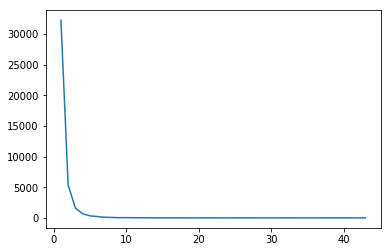

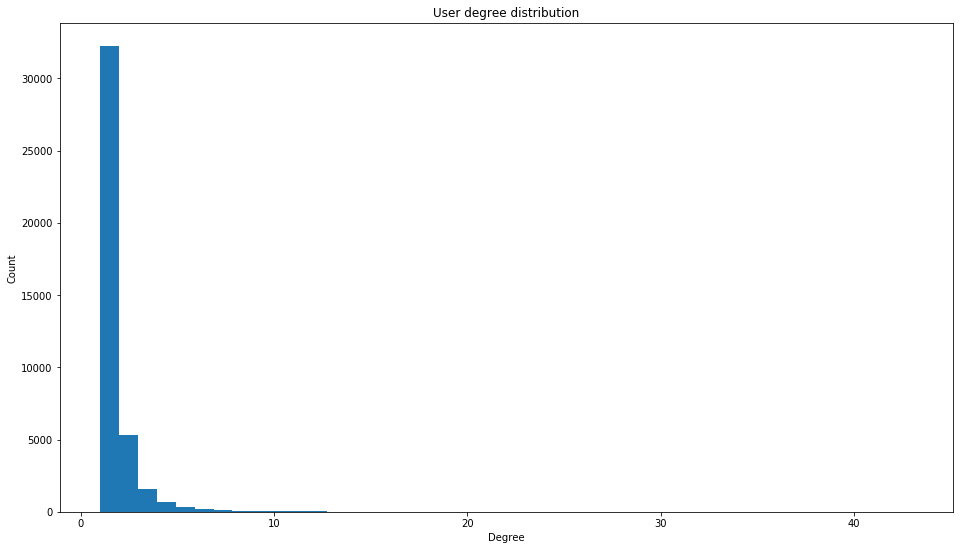

In [10]:
# Out-degree of users
users_out = Stargaze_Network.out_degree(users)

# Degrees only
users_deg = [d[1] for d in users_out]

# Make Histogram
users_hist, users_bin = np.histogram(users_deg, bins=max(users_deg))
print(users_hist)

plt.plot([x+1 for x in range(max(users_deg))], users_hist)
plt.show()

fig = plt.figure(figsize=(16,9))
plt.hist(users_deg, bins=max(users_deg))
plt.title("User degree distribution")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()

This distribution follows a heavy power law. Many users only follow 1 or 2 currencies, the max is 43.

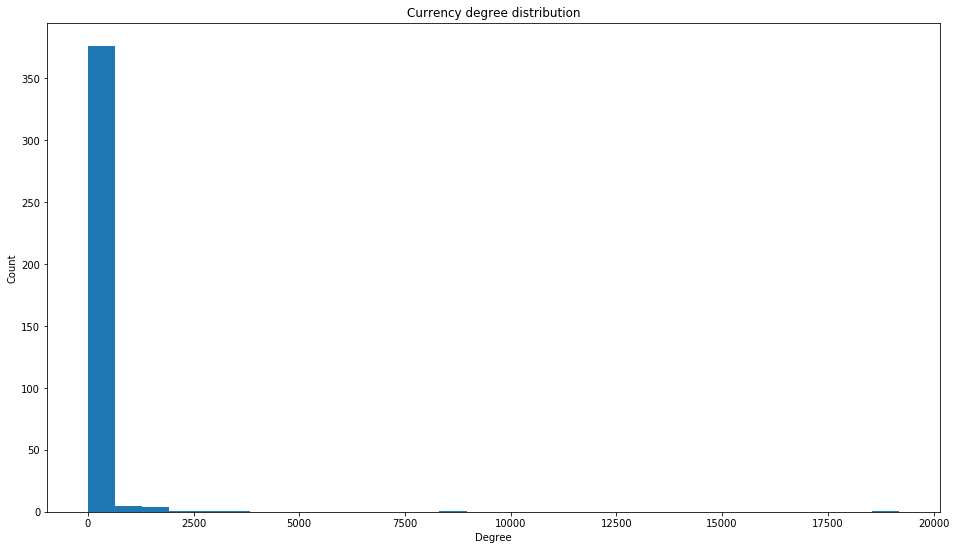

In [13]:
# In-degrees of currencies
curr_in = Stargaze_Network.in_degree(currencies)

# Degrees only
curr_deg = [d[1] for d in curr_in]

# Make Histogram
fig = plt.figure(figsize=(16,9))
plt.hist(curr_deg, bins=30)
plt.title("Currency degree distribution")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()

Here, bitcoin (obviously) takes the cake with nearly 20000 stargazers. Most currencies have only a few followers. This is a power-law dstribution again.

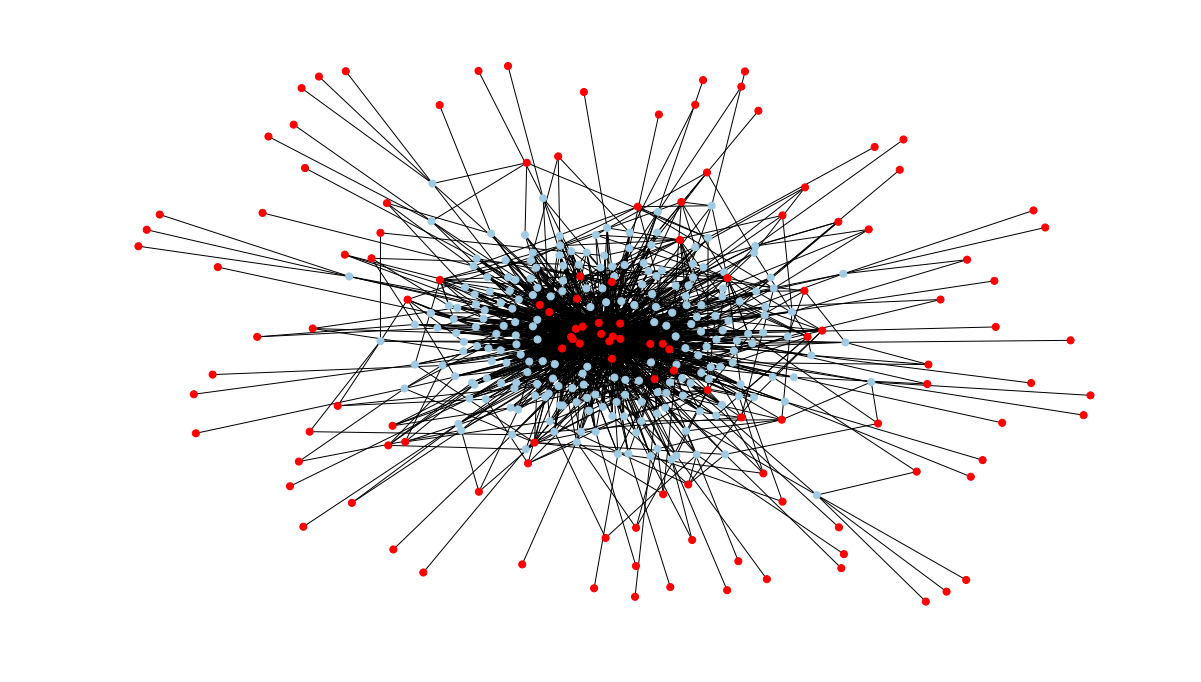

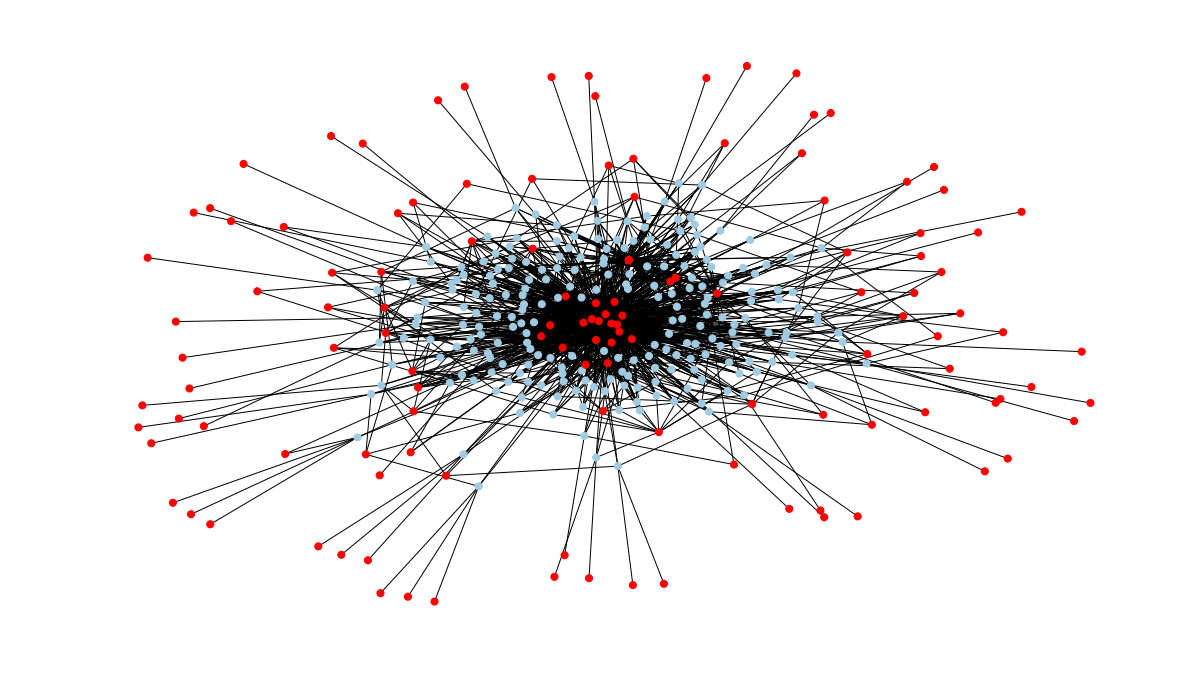

In [29]:
# Find users with degree>1
users_1=[]
for x in users_out:
    if x[1]==6:
        users_1.append(x[0])
   
star_manygaze = Stargaze_Network.subgraph(users_1+currencies)

curr_1=[]
for x in star_manygaze.in_degree(currencies):
    if x[1]>0:
        curr_1.append(x[0])
        
star_manygaze = Stargaze_Network.subgraph(users_1+curr_1)

colors=[]
for node, data in star_manygaze.nodes(data=True):
    if data["Type"]=="User":
        colors.append("#A0CBE2")
    else:
        colors.append("#FF0000")

fig = plt.figure(figsize=(16,9))
nx.draw_spring(star_manygaze.to_undirected(), node_size=50, node_color=colors)
#plt.savefig('showgraph.png')
plt.show()

# Follower similarity

## Goal: Find similarities between follower groups of different cryptocurrencies

### Step 1: For all CC pairs, create a dictionary of followers



In [17]:
cc_pairs = list(it.combinations(currencies, 2))

print(len(cc_pairs))

common_user_dict = {}

for pair in cc_pairs:
    users_1 = set([x.login for x in crypto_stargazers_dict[pair[0]]])
    users_2 = set([x.login for x in crypto_stargazers_dict[pair[1]]])
    common_stars = list(users_1 & users_2)
    common_user_dict[pair] = common_stars



75855


In [15]:
print(common_user_dict[('bitcoin', 'ethereum')])

['methuz', 'Shivprakash', 'mikeumus', 'madraslabs', 'hhakala', 'skllcrn', 'highlanderkev', 'phohtoo', 'ZeemanHuang', 'bezalel', 'lightning-li', 'yagobski', 'Thoughtscript', 'TySabs', 'macosunity', 'chartractegg', 'junit', 'whoisjake', 'jeremyburr', 'kyoyadmoon', 'andrewnsk', 'ytbryan', 'seungjulee', 'tinybike', 'mimizhang', 'abbasovalex', 'vivekyadav01', 'emacsvi', 'kennyalive', 'capitulation', 'mauris', 'soediro', 'ymmuse', 'hzitoun', 'NodeGuy', 'WenHou', 'aroyer', 'njiang1987', 'QPIpattern', 'vdt', 'vach', 'lrettig', 'lbensaad', 'L-AY', 'renterial', 'fyesgo', 'Richard-Cao', 'juliandv', '0ng0n', 'holaaworld', 'cmdspace', 'RiteshChandnani', 'brtn', 'Szkered', '100ps', 'markysharky70', 'tranvictor', 'si-vis-pacem', 'dchapkine', 'beicare', 'Jackneill', 'Abdelkrim', 'jonhermansen', 'alexined', 'dibu28', 'askari01', 'cnodin', 'wlMalk', 'JepsonWong', 'aimanbaharum', 'hccpeng', 'syncord', 'lemenkov', 'kotarac', 'sidkshatriya', 'johnsonchandra', 'avimehenwal', 'aaronsung', 'HenrySlawniak', 't

### Step 2: Define a similarity between two user lists

First, we need to set how we want do define the similarity of two user groups. The most sound way to do this is via the Jaccard similarity measure. It measures which fraction of elements in the union of two sets is in their intersection:

$$J(A,B) = \frac{|A\cap B|}{|A\cup B|}$$

We will now define a function that calculates this exact similarity:

In [18]:
def jaccard_currencies(pair):
    c1=pair[0]
    c2=pair[1]
    
    n1=len(set([x.login for x in crypto_stargazers_dict[c1]]))
    n2=len(set([x.login for x in crypto_stargazers_dict[c2]]))
    n12=len(common_user_dict[pair])
    
    try:
        J=n12/(n1+n2-n12)
    except:
        if n12==0:
            J=0
        else:
            J=1
    return(J)

In [21]:
cc_similarity={}
for pair in cc_pairs:
    cc_similarity[pair]=jaccard_currencies(pair)
    
print(cc_similarity[('bitcoin', 'ethereum')])

0.09223886403423459


**A few observations**

In [22]:
print(cc_similarity[('ethereum', 'ripple')])

print(sorted(cc_similarity, key=cc_similarity.get, reverse=True)[:10])

print(crypto_stargazers_dict['1337'])
print(crypto_stargazers_dict['falcoin'])

print(np.mean(list(cc_similarity.values())))

0.036054622261518815
[('steem', 'steem-dollars'), ('nav-coin', 'bitdeal'), ('e-dinar-coin', 'edrcoin'), ('breakout-stake', 'breakout'), ('ultracoin', 'incakoin'), ('zurcoin', 'argentum'), ('cypher', 'spacecoin'), ('1337', 'falcoin'), ('britcoin', 'ratecoin'), ('virtacoinplus', 'virtacoin')]
[NamedUser(login="ficusplant"), NamedUser(login="zelda180"), NamedUser(login="konyzulphrea"), NamedUser(login="tureki")]
[NamedUser(login="ficusplant"), NamedUser(login="zelda180"), NamedUser(login="konyzulphrea"), NamedUser(login="tureki")]
0.00153690720427


distribution of similarities

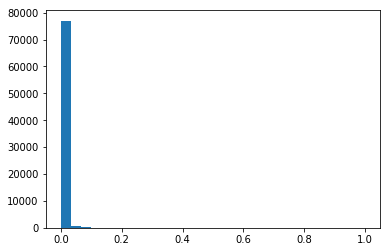

In [50]:
plt.hist(cc_similarity.values(), bins=30)
plt.show()

### Step 3: Analysis of one similarity entries



In [55]:
cc_similarity_one = dict((k, v) for k, v in cc_similarity.items() if v == 1)

for key, value in cc_similarity_one.items():
    cc_similarity_one[key]=(len(crypto_stargazers_dict[key[0]]), len(crypto_stargazers_dict[key[1]]))

print(cc_similarity_one)
    

{('steem', 'steem-dollars'): (648, 648), ('nav-coin', 'bitdeal'): (26, 26), ('e-dinar-coin', 'edrcoin'): (5, 5), ('breakout-stake', 'breakout'): (5, 5), ('ultracoin', 'incakoin'): (1, 1), ('zurcoin', 'argentum'): (1, 1), ('cypher', 'spacecoin'): (1, 1), ('1337', 'falcoin'): (4, 4), ('britcoin', 'ratecoin'): (1, 1), ('virtacoinplus', 'virtacoin'): (73, 73)}


We may disregard repositories with only one stargazer. These have no informative value.
The others are pretty self-explanatory: Currencies with similar names (steem, steem-dollars) simply share the same github repository thus have the same stargazers.

### Step 4: Analysis of zero similarity entries

Get data

In [45]:
cc_similarity_zero = dict((k, v) for k, v in cc_similarity.items() if v == 0)
empty_cc = dict((k, v) for k, v in crypto_stargazers_dict.items() if len(v)==0)


for key, value in cc_similarity_zero.items():
    print(key)

('bitcoin', 'nolimitcoin')
('bitcoin', 'leocoin')
('bitcoin', 'einsteinium')
('bitcoin', 'toacoin')
('bitcoin', 'salus')
('bitcoin', 'whitecoin')
('bitcoin', 'abjcoin')
('bitcoin', 'masternodecoin')
('bitcoin', 'heat')
('bitcoin', 'bitbean')
('bitcoin', 'dimecoin')
('bitcoin', 'earthcoin')
('bitcoin', 'yocoin')
('bitcoin', 'evergreencoin')
('bitcoin', 'hush')
('bitcoin', 'terracoin')
('bitcoin', 'trustplus')
('bitcoin', 'karbowanec')
('bitcoin', 'bluecoin')
('bitcoin', 'quark')
('bitcoin', 'parkbyte')
('bitcoin', 'dopecoin')
('bitcoin', 'huntercoin')
('bitcoin', 'visio')
('bitcoin', 'woodcoin')
('bitcoin', 'luckchain')
('bitcoin', 'renos')
('bitcoin', 'signatum')
('bitcoin', 'adzcoin')
('bitcoin', 'influxcoin')
('bitcoin', 'cryptocarbon')
('bitcoin', 'ultracoin')
('bitcoin', 'insanecoin')
('bitcoin', 'unbreakablecoin')
('bitcoin', 'teslacoin')
('bitcoin', 'ellaism')
('bitcoin', 'triangles')
('bitcoin', 'veltor')
('bitcoin', 'mincoin')
('bitcoin', 'embercoin')
('bitcoin', 'trumpcoin')
(

('neo', 'heat')
('neo', 'bitbean')
('neo', 'dimecoin')
('neo', 'xtrabytes')
('neo', 'dynamic')
('neo', 'goldcoin')
('neo', 'auroracoin')
('neo', 'exclusivecoin')
('neo', 'pesetacoin')
('neo', 'synergy')
('neo', 'yocoin')
('neo', 'newyorkcoin')
('neo', 'blitzcash')
('neo', 'evergreencoin')
('neo', 'hush')
('neo', 'terracoin')
('neo', 'audiocoin')
('neo', 'trustplus')
('neo', 'geocoin')
('neo', 'memetic')
('neo', 'bridgecoin')
('neo', '2give')
('neo', 'sexcoin')
('neo', 'karbowanec')
('neo', 'vivo')
('neo', 'bluecoin')
('neo', 'dnotes')
('neo', 'mintcoin')
('neo', 'quark')
('neo', 'innova')
('neo', 'parkbyte')
('neo', 'riecoin')
('neo', 'dopecoin')
('neo', 'huntercoin')
('neo', 'visio')
('neo', 'worldcoin')
('neo', 'onix')
('neo', 'woodcoin')
('neo', 'magi')
('neo', 'megacoin')
('neo', 'luckchain')
('neo', 'arcticcoin')
('neo', 'dotcoin')
('neo', 'pirl')
('neo', 'espers')
('neo', 'cryptonite')
('neo', 'renos')
('neo', 'trezarcoin')
('neo', 'bitcoinz')
('neo', 'unitus')
('neo', 'signatum'

('cardano', 'tyrocoin')
('cardano', 'goldmaxcoin')
('cardano', 'edrcoin')
('cardano', 'royalties')
('cardano', 'hyper')
('cardano', 'kashhcoin')
('cardano', 'magnetcoin')
('bitconnect', 'stratis')
('bitconnect', 'monacoin')
('bitconnect', 'bitcoindark')
('bitconnect', 'gamecredits')
('bitconnect', 'blocknet')
('bitconnect', 'gxshares')
('bitconnect', 'pura')
('bitconnect', 'faircoin')
('bitconnect', 'nolimitcoin')
('bitconnect', 'bitbay')
('bitconnect', 'groestlcoin')
('bitconnect', 'achain')
('bitconnect', 'cloakcoin')
('bitconnect', 'rise')
('bitconnect', 'bitcore')
('bitconnect', 'emercoin')
('bitconnect', 'leocoin')
('bitconnect', 'aeon')
('bitconnect', 'einsteinium')
('bitconnect', 'diamond')
('bitconnect', 'sibcoin')
('bitconnect', 'feathercoin')
('bitconnect', 'minexcoin')
('bitconnect', 'ion')
('bitconnect', 'raiblocks')
('bitconnect', 'rubycoin')
('bitconnect', 'solarcoin')
('bitconnect', 'smartcash')
('bitconnect', 'expanse')
('bitconnect', 'toacoin')
('bitconnect', 'bitsend'

('komodo', 'bitgem')
('komodo', 'fluttercoin')
('komodo', 'acoin')
('komodo', 'cannacoin')
('komodo', 'theresa-may-coin')
('komodo', 'zurcoin')
('komodo', 'cryptojacks')
('komodo', 'goldblocks')
('komodo', 'blakecoin')
('komodo', 'campuscoin')
('komodo', 'catcoin')
('komodo', 'usde')
('komodo', 'roofs')
('komodo', 'cypher')
('komodo', 'boostcoin')
('komodo', 'master-swiscoin')
('komodo', 'solarflarecoin')
('komodo', 'crevacoin')
('komodo', 'geertcoin')
('komodo', 'grimcoin')
('komodo', 'litebitcoin')
('komodo', '1337')
('komodo', 'falcoin')
('komodo', 'yashcoin')
('komodo', 'asiacoin')
('komodo', 'martexcoin')
('komodo', 'infinitecoin')
('komodo', 'cryptcoin')
('komodo', 'incakoin')
('komodo', 'hitcoin')
('komodo', 'anoncoin')
('komodo', 'pandacoin')
('komodo', 'shadowcash')
('komodo', 'canada-ecoin')
('komodo', 'bitstar')
('komodo', 'hobonickels')
('komodo', 'bitbar')
('komodo', 'orbitcoin')
('komodo', 'britcoin')
('komodo', 'trollcoin')
('komodo', 'swagbucks')
('komodo', 'ambercoin')

('factom', 'ellaism')
('factom', 'tagcoin')
('factom', 'sprouts')
('factom', 'triangles')
('factom', 'digitalprice')
('factom', 'pakcoin')
('factom', 'deutsche-emark')
('factom', 'fujicoin')
('factom', 'vsync')
('factom', 'cagecoin')
('factom', 'veltor')
('factom', 'ethereum-dark')
('factom', 'mincoin')
('factom', 'embercoin')
('factom', 'trumpcoin')
('factom', 'joulecoin')
('factom', 'nyancoin')
('factom', 'bitgem')
('factom', 'fluttercoin')
('factom', 'acoin')
('factom', 'cannacoin')
('factom', 'theresa-may-coin')
('factom', 'zurcoin')
('factom', 'cryptojacks')
('factom', 'goldblocks')
('factom', 'blakecoin')
('factom', 'campuscoin')
('factom', 'catcoin')
('factom', 'usde')
('factom', 'roofs')
('factom', 'cypher')
('factom', 'boostcoin')
('factom', 'master-swiscoin')
('factom', 'solarflarecoin')
('factom', 'crevacoin')
('factom', 'geertcoin')
('factom', 'grimcoin')
('factom', 'litebitcoin')
('factom', '1337')
('factom', 'falcoin')
('factom', 'yashcoin')
('factom', 'asiacoin')
('facto

('lykke', 'salus')
('lykke', 'monetaryunit')
('lykke', 'radium')
('lykke', 'prizm')
('lykke', 'whitecoin')
('lykke', 'florincoin')
('lykke', 'transfercoin')
('lykke', 'centurion')
('lykke', 'novacoin')
('lykke', 'abjcoin')
('lykke', 'lomocoin')
('lykke', 'spectrecoin')
('lykke', 'htmlcoin')
('lykke', 'mooncoin')
('lykke', 'unobtanium')
('lykke', 'masternodecoin')
('lykke', 'gambit')
('lykke', 'bitcoin-plus')
('lykke', 'e-dinar-coin')
('lykke', 'pinkcoin')
('lykke', 'heat')
('lykke', 'bitbean')
('lykke', 'dimecoin')
('lykke', 'xtrabytes')
('lykke', 'stealthcoin')
('lykke', 'casinocoin')
('lykke', 'dynamic')
('lykke', 'curecoin')
('lykke', 'goldcoin')
('lykke', 'sequence')
('lykke', 'musicoin')
('lykke', 'auroracoin')
('lykke', 'posw-coin')
('lykke', 'rupee')
('lykke', 'tao')
('lykke', 'exclusivecoin')
('lykke', 'pesetacoin')
('lykke', 'synergy')
('lykke', 'bitswift')
('lykke', 'chaincoin')
('lykke', 'earthcoin')
('lykke', 'yocoin')
('lykke', 'newyorkcoin')
('lykke', 'blitzcash')
('lykke

('zencash', 'cloakcoin')
('zencash', 'bitcore')
('zencash', 'emercoin')
('zencash', 'leocoin')
('zencash', 'einsteinium')
('zencash', 'diamond')
('zencash', 'namecoin')
('zencash', 'sibcoin')
('zencash', 'feathercoin')
('zencash', 'minexcoin')
('zencash', 'ion')
('zencash', 'rubycoin')
('zencash', 'solarcoin')
('zencash', 'smartcash')
('zencash', 'expanse')
('zencash', 'toacoin')
('zencash', 'bitsend')
('zencash', 'digitalnote')
('zencash', 'clams')
('zencash', 'dubaicoin')
('zencash', 'energycoin')
('zencash', 'salus')
('zencash', 'radium')
('zencash', 'asch')
('zencash', 'prizm')
('zencash', 'whitecoin')
('zencash', 'transfercoin')
('zencash', 'centurion')
('zencash', 'novacoin')
('zencash', 'abjcoin')
('zencash', 'lomocoin')
('zencash', 'spectrecoin')
('zencash', 'htmlcoin')
('zencash', 'unobtanium')
('zencash', 'gambit')
('zencash', 'bitcoin-plus')
('zencash', 'e-dinar-coin')
('zencash', 'pinkcoin')
('zencash', 'heat')
('zencash', 'bitbean')
('zencash', 'dimecoin')
('zencash', 'xtr

('counterparty', 'bitcoin-scrypt')
('counterparty', 'truckcoin')
('counterparty', 'piggycoin')
('counterparty', 'purevidz')
('counterparty', 'titcoin')
('counterparty', 'hodlcoin')
('counterparty', 'the-cypherfunks')
('counterparty', 'shilling')
('counterparty', 'grantcoin')
('counterparty', 'bunnycoin')
('counterparty', 'digicube')
('counterparty', 'kushcoin')
('counterparty', 'biblepay')
('counterparty', 'digitalcoin')
('counterparty', 'ratecoin')
('counterparty', 'revolvercoin')
('counterparty', 'paycoin')
('counterparty', 'crypto')
('counterparty', 'swing')
('counterparty', 'mojocoin')
('counterparty', 'tittiecoin')
('counterparty', 'virtualcoin')
('counterparty', 'bottlecaps')
('counterparty', 'droxne')
('counterparty', 'octocoin')
('counterparty', 'sativacoin')
('counterparty', 'spacecoin')
('counterparty', 'cachecoin')
('counterparty', 'quatloo')
('counterparty', 'wmcoin')
('counterparty', 'goldpieces')
('counterparty', 'jobscoin')
('counterparty', 'argentum')
('counterparty', '

('viacoin', 'cryptojacks')
('viacoin', 'goldblocks')
('viacoin', 'blakecoin')
('viacoin', 'campuscoin')
('viacoin', 'catcoin')
('viacoin', 'usde')
('viacoin', 'roofs')
('viacoin', 'cypher')
('viacoin', 'boostcoin')
('viacoin', 'master-swiscoin')
('viacoin', 'solarflarecoin')
('viacoin', 'crevacoin')
('viacoin', 'geertcoin')
('viacoin', 'grimcoin')
('viacoin', 'litebitcoin')
('viacoin', '1337')
('viacoin', 'falcoin')
('viacoin', 'yashcoin')
('viacoin', 'asiacoin')
('viacoin', 'infinitecoin')
('viacoin', 'cryptcoin')
('viacoin', 'incakoin')
('viacoin', 'hitcoin')
('viacoin', 'anoncoin')
('viacoin', 'pandacoin')
('viacoin', 'shadowcash')
('viacoin', 'canada-ecoin')
('viacoin', 'bitstar')
('viacoin', 'hobonickels')
('viacoin', 'bitbar')
('viacoin', 'maxcoin')
('viacoin', 'orbitcoin')
('viacoin', 'britcoin')
('viacoin', 'trollcoin')
('viacoin', 'swagbucks')
('viacoin', 'ambercoin')
('viacoin', 'mazacoin')
('viacoin', 'gaia')
('viacoin', 'sterlingcoin')
('viacoin', 'fuelcoin')
('viacoin', 'd

('bitcore', 'swing')
('bitcore', 'mojocoin')
('bitcore', 'tittiecoin')
('bitcore', 'virtualcoin')
('bitcore', 'bottlecaps')
('bitcore', 'droxne')
('bitcore', 'octocoin')
('bitcore', 'sativacoin')
('bitcore', 'spacecoin')
('bitcore', 'cachecoin')
('bitcore', 'quatloo')
('bitcore', 'wmcoin')
('bitcore', 'goldpieces')
('bitcore', 'jobscoin')
('bitcore', 'argentum')
('bitcore', 'kurrent')
('bitcore', 'franko')
('bitcore', 'globaltoken')
('bitcore', 'metal-music-coin')
('bitcore', 'virtacoinplus')
('bitcore', 'secretcoin')
('bitcore', 'rimbit')
('bitcore', 'macron')
('bitcore', 'hexx')
('bitcore', 'benjirolls')
('bitcore', 'uro')
('bitcore', 'soilcoin')
('bitcore', 'playercoin')
('bitcore', 'comet')
('bitcore', 'pesobit')
('bitcore', 'steps')
('bitcore', 'slevin')
('bitcore', 'zonecoin')
('bitcore', 'kronecoin')
('bitcore', 'wexcoin')
('bitcore', 'rsgpcoin')
('bitcore', 'frazcoin')
('bitcore', 'virtacoin')
('bitcore', 'enigma')
('bitcore', 'bigboobscoin')
('bitcore', 'mantracoin')
('bitcore

('einsteinium', 'deutsche-emark')
('einsteinium', 'fujicoin')
('einsteinium', 'vsync')
('einsteinium', 'cagecoin')
('einsteinium', 'veltor')
('einsteinium', 'ethereum-dark')
('einsteinium', 'mincoin')
('einsteinium', 'embercoin')
('einsteinium', 'trumpcoin')
('einsteinium', 'joulecoin')
('einsteinium', 'nyancoin')
('einsteinium', 'bitgem')
('einsteinium', 'fluttercoin')
('einsteinium', 'acoin')
('einsteinium', 'cannacoin')
('einsteinium', 'theresa-may-coin')
('einsteinium', 'zurcoin')
('einsteinium', 'cryptojacks')
('einsteinium', 'goldblocks')
('einsteinium', 'blakecoin')
('einsteinium', 'campuscoin')
('einsteinium', 'catcoin')
('einsteinium', 'usde')
('einsteinium', 'roofs')
('einsteinium', 'cypher')
('einsteinium', 'boostcoin')
('einsteinium', 'master-swiscoin')
('einsteinium', 'solarflarecoin')
('einsteinium', 'crevacoin')
('einsteinium', 'geertcoin')
('einsteinium', 'grimcoin')
('einsteinium', 'litebitcoin')
('einsteinium', '1337')
('einsteinium', 'falcoin')
('einsteinium', 'yashc

('raiblocks', 'lomocoin')
('raiblocks', 'spectrecoin')
('raiblocks', 'htmlcoin')
('raiblocks', 'mooncoin')
('raiblocks', 'masternodecoin')
('raiblocks', 'gambit')
('raiblocks', 'e-dinar-coin')
('raiblocks', 'pinkcoin')
('raiblocks', 'heat')
('raiblocks', 'bitbean')
('raiblocks', 'dimecoin')
('raiblocks', 'xtrabytes')
('raiblocks', 'casinocoin')
('raiblocks', 'dynamic')
('raiblocks', 'curecoin')
('raiblocks', 'goldcoin')
('raiblocks', 'musicoin')
('raiblocks', 'auroracoin')
('raiblocks', 'posw-coin')
('raiblocks', 'rupee')
('raiblocks', 'tao')
('raiblocks', 'exclusivecoin')
('raiblocks', 'pesetacoin')
('raiblocks', 'synergy')
('raiblocks', 'bitswift')
('raiblocks', 'earthcoin')
('raiblocks', 'yocoin')
('raiblocks', 'newyorkcoin')
('raiblocks', 'blitzcash')
('raiblocks', 'evergreencoin')
('raiblocks', 'hush')
('raiblocks', 'veriumreserve')
('raiblocks', 'terracoin')
('raiblocks', 'audiocoin')
('raiblocks', 'bitmark')
('raiblocks', 'zeitcoin')
('raiblocks', 'primecoin')
('raiblocks', 'tru

('vericoin', 'dubaicoin')
('vericoin', 'energycoin')
('vericoin', 'salus')
('vericoin', 'radium')
('vericoin', 'prizm')
('vericoin', 'whitecoin')
('vericoin', 'transfercoin')
('vericoin', 'centurion')
('vericoin', 'abjcoin')
('vericoin', 'lomocoin')
('vericoin', 'spectrecoin')
('vericoin', 'htmlcoin')
('vericoin', 'mooncoin')
('vericoin', 'masternodecoin')
('vericoin', 'gambit')
('vericoin', 'bitcoin-plus')
('vericoin', 'pinkcoin')
('vericoin', 'heat')
('vericoin', 'bitbean')
('vericoin', 'dimecoin')
('vericoin', 'xtrabytes')
('vericoin', 'stealthcoin')
('vericoin', 'casinocoin')
('vericoin', 'dynamic')
('vericoin', 'curecoin')
('vericoin', 'goldcoin')
('vericoin', 'sequence')
('vericoin', 'musicoin')
('vericoin', 'posw-coin')
('vericoin', 'rupee')
('vericoin', 'tao')
('vericoin', 'exclusivecoin')
('vericoin', 'pesetacoin')
('vericoin', 'synergy')
('vericoin', 'chaincoin')
('vericoin', 'earthcoin')
('vericoin', 'yocoin')
('vericoin', 'newyorkcoin')
('vericoin', 'blitzcash')
('vericoin'

('shift', 'maxcoin')
('shift', 'orbitcoin')
('shift', 'britcoin')
('shift', 'trollcoin')
('shift', 'swagbucks')
('shift', 'ambercoin')
('shift', 'mazacoin')
('shift', 'gaia')
('shift', 'sterlingcoin')
('shift', 'fuelcoin')
('shift', 'daxxcoin')
('shift', 'noblecoin')
('shift', 'smartcoin')
('shift', 'eternity')
('shift', 'electra')
('shift', 'joincoin')
('shift', 'bitcoin-scrypt')
('shift', 'truckcoin')
('shift', 'piggycoin')
('shift', 'opal')
('shift', 'purevidz')
('shift', 'titcoin')
('shift', 'hodlcoin')
('shift', 'the-cypherfunks')
('shift', 'shilling')
('shift', 'freicoin')
('shift', 'grantcoin')
('shift', 'bunnycoin')
('shift', 'digicube')
('shift', 'kushcoin')
('shift', 'biblepay')
('shift', 'digitalcoin')
('shift', 'ratecoin')
('shift', 'revolvercoin')
('shift', 'paycoin')
('shift', 'crypto')
('shift', 'quazarcoin')
('shift', 'swing')
('shift', 'mojocoin')
('shift', 'tittiecoin')
('shift', 'virtualcoin')
('shift', 'bottlecaps')
('shift', 'droxne')
('shift', 'octocoin')
('shift'

('asch', 'riecoin')
('asch', 'bismuth')
('asch', 'spreadcoin')
('asch', 'dopecoin')
('asch', 'huntercoin')
('asch', 'fimkrypto')
('asch', 'creativecoin')
('asch', 'visio')
('asch', 'worldcoin')
('asch', 'vtorrent')
('asch', 'onix')
('asch', 'cannabiscoin')
('asch', 'woodcoin')
('asch', 'magi')
('asch', 'megacoin')
('asch', 'luckchain')
('asch', 'arcticcoin')
('asch', 'dotcoin')
('asch', 'pirl')
('asch', 'espers')
('asch', 'cryptonite')
('asch', 'renos')
('asch', 'trezarcoin')
('asch', 'bitcoinz')
('asch', 'unitus')
('asch', 'signatum')
('asch', 'adzcoin')
('asch', 'influxcoin')
('asch', 'bitzeny')
('asch', 'fastcoin')
('asch', 'cryptocarbon')
('asch', 'ultracoin')
('asch', 'machinecoin')
('asch', 'insanecoin')
('asch', 'bitradio')
('asch', 'monacocoin')
('asch', 'sumokoin')
('asch', 'fantomcoin')
('asch', 'capricoin')
('asch', 'unbreakablecoin')
('asch', 'zetacoin')
('asch', 'teslacoin')
('asch', 'bata')
('asch', 'torcoin')
('asch', 'netcoin')
('asch', 'denarius')
('asch', 'linda')
('a

('centurion', 'hexx')
('centurion', 'benjirolls')
('centurion', 'uro')
('centurion', 'soilcoin')
('centurion', 'playercoin')
('centurion', 'comet')
('centurion', 'pesobit')
('centurion', 'steps')
('centurion', 'slevin')
('centurion', 'zonecoin')
('centurion', 'kronecoin')
('centurion', 'wexcoin')
('centurion', 'rsgpcoin')
('centurion', 'frazcoin')
('centurion', 'virtacoin')
('centurion', 'enigma')
('centurion', 'bigboobscoin')
('centurion', 'mantracoin')
('centurion', 'geysercoin')
('centurion', 'ulatech')
('centurion', 'applecoin')
('centurion', 'bitcoin-gold')
('centurion', 'clubcoin')
('centurion', 'phore')
('centurion', 'boscoin')
('centurion', 'desire')
('centurion', 'gulfcoin')
('centurion', 'terranova')
('centurion', 'bitbase')
('centurion', 'vulcano')
('centurion', 'buzzcoin')
('centurion', 'vpncoin')
('centurion', 'paccoin')
('centurion', 'force')
('centurion', 'dfscoin')
('centurion', 'starcash-network')
('centurion', 'flash')
('centurion', 'stronghands')
('centurion', 'amste

('masternodecoin', 'zetacoin')
('masternodecoin', 'teslacoin')
('masternodecoin', 'bata')
('masternodecoin', 'torcoin')
('masternodecoin', 'netcoin')
('masternodecoin', 'denarius')
('masternodecoin', 'linda')
('masternodecoin', 'colossuscoinxt')
('masternodecoin', 'luxcoin')
('masternodecoin', 'phoenixcoin')
('masternodecoin', 'ellaism')
('masternodecoin', 'dashcoin')
('masternodecoin', 'tagcoin')
('masternodecoin', 'sprouts')
('masternodecoin', 'triangles')
('masternodecoin', 'digitalprice')
('masternodecoin', 'pakcoin')
('masternodecoin', 'deutsche-emark')
('masternodecoin', 'fujicoin')
('masternodecoin', 'vsync')
('masternodecoin', 'cagecoin')
('masternodecoin', 'veltor')
('masternodecoin', 'ethereum-dark')
('masternodecoin', 'mincoin')
('masternodecoin', 'embercoin')
('masternodecoin', 'trumpcoin')
('masternodecoin', 'joulecoin')
('masternodecoin', 'nyancoin')
('masternodecoin', 'bitgem')
('masternodecoin', 'fluttercoin')
('masternodecoin', 'acoin')
('masternodecoin', 'cannacoin')


('bitbean', 'comet')
('bitbean', 'pesobit')
('bitbean', 'steps')
('bitbean', 'slevin')
('bitbean', 'zonecoin')
('bitbean', 'kronecoin')
('bitbean', 'wexcoin')
('bitbean', 'rsgpcoin')
('bitbean', 'frazcoin')
('bitbean', 'virtacoin')
('bitbean', 'enigma')
('bitbean', 'bigboobscoin')
('bitbean', 'mantracoin')
('bitbean', 'geysercoin')
('bitbean', 'ulatech')
('bitbean', 'applecoin')
('bitbean', 'bitcoin-gold')
('bitbean', 'clubcoin')
('bitbean', 'phore')
('bitbean', 'boscoin')
('bitbean', 'desire')
('bitbean', 'gulfcoin')
('bitbean', 'terranova')
('bitbean', 'bitbase')
('bitbean', 'vulcano')
('bitbean', 'buzzcoin')
('bitbean', 'vpncoin')
('bitbean', 'paccoin')
('bitbean', 'force')
('bitbean', 'dfscoin')
('bitbean', 'starcash-network')
('bitbean', 'flash')
('bitbean', 'stronghands')
('bitbean', 'amsterdamcoin')
('bitbean', 'adcoin')
('bitbean', 'namocoin')
('bitbean', 'protean')
('bitbean', 'avoncoin')
('bitbean', 'runners')
('bitbean', 'moneta')
('bitbean', 'qora')
('bitbean', 'cyder')
('b

('sequence', 'trustplus')
('sequence', 'geocoin')
('sequence', 'memetic')
('sequence', 'breakout-stake')
('sequence', 'bridgecoin')
('sequence', '2give')
('sequence', 'sexcoin')
('sequence', 'karbowanec')
('sequence', 'vivo')
('sequence', 'bluecoin')
('sequence', 'breakout')
('sequence', 'deeponion')
('sequence', 'dnotes')
('sequence', 'mintcoin')
('sequence', 'quark')
('sequence', 'innova')
('sequence', 'parkbyte')
('sequence', 'fedoracoin')
('sequence', 'ixcoin')
('sequence', 'riecoin')
('sequence', 'bismuth')
('sequence', 'spreadcoin')
('sequence', 'crave')
('sequence', 'dopecoin')
('sequence', 'huntercoin')
('sequence', 'fimkrypto')
('sequence', 'creativecoin')
('sequence', 'visio')
('sequence', 'worldcoin')
('sequence', 'vtorrent')
('sequence', 'onix')
('sequence', 'cannabiscoin')
('sequence', 'woodcoin')
('sequence', 'magi')
('sequence', 'startcoin')
('sequence', 'megacoin')
('sequence', 'luckchain')
('sequence', 'arcticcoin')
('sequence', 'dotcoin')
('sequence', 'pirl')
('sequen

('pesetacoin', 'desire')
('pesetacoin', 'gulfcoin')
('pesetacoin', 'terranova')
('pesetacoin', 'bitbase')
('pesetacoin', 'vulcano')
('pesetacoin', 'buzzcoin')
('pesetacoin', 'vpncoin')
('pesetacoin', 'paccoin')
('pesetacoin', 'force')
('pesetacoin', 'dfscoin')
('pesetacoin', 'starcash-network')
('pesetacoin', 'flash')
('pesetacoin', 'stronghands')
('pesetacoin', 'amsterdamcoin')
('pesetacoin', 'adcoin')
('pesetacoin', 'namocoin')
('pesetacoin', 'protean')
('pesetacoin', 'avoncoin')
('pesetacoin', 'runners')
('pesetacoin', 'moneta')
('pesetacoin', 'qora')
('pesetacoin', 'cyder')
('pesetacoin', 'utacoin')
('pesetacoin', 'lepen')
('pesetacoin', 'sakuracoin')
('pesetacoin', 'sync')
('pesetacoin', 'bitcedi')
('pesetacoin', 'tyrocoin')
('pesetacoin', 'goldmaxcoin')
('pesetacoin', 'edrcoin')
('pesetacoin', 'royalties')
('pesetacoin', 'hyper')
('pesetacoin', 'kashhcoin')
('pesetacoin', 'magnetcoin')
('pesetacoin', 'peoplecoin')
('synergy', 'bitswift')
('synergy', 'chaincoin')
('synergy', 'eart

('evergreencoin', 'capricoin')
('evergreencoin', 'unbreakablecoin')
('evergreencoin', 'zetacoin')
('evergreencoin', 'teslacoin')
('evergreencoin', 'bata')
('evergreencoin', 'torcoin')
('evergreencoin', 'netcoin')
('evergreencoin', 'denarius')
('evergreencoin', 'linda')
('evergreencoin', 'colossuscoinxt')
('evergreencoin', 'luxcoin')
('evergreencoin', 'phoenixcoin')
('evergreencoin', 'ellaism')
('evergreencoin', 'dashcoin')
('evergreencoin', 'tagcoin')
('evergreencoin', 'sprouts')
('evergreencoin', 'triangles')
('evergreencoin', 'digitalprice')
('evergreencoin', 'pakcoin')
('evergreencoin', 'deutsche-emark')
('evergreencoin', 'fujicoin')
('evergreencoin', 'vsync')
('evergreencoin', 'cagecoin')
('evergreencoin', 'veltor')
('evergreencoin', 'ethereum-dark')
('evergreencoin', 'mincoin')
('evergreencoin', 'embercoin')
('evergreencoin', 'trumpcoin')
('evergreencoin', 'joulecoin')
('evergreencoin', 'nyancoin')
('evergreencoin', 'bitgem')
('evergreencoin', 'fluttercoin')
('evergreencoin', 'aco

('audiocoin', 'bunnycoin')
('audiocoin', 'digicube')
('audiocoin', 'kushcoin')
('audiocoin', 'biblepay')
('audiocoin', 'digitalcoin')
('audiocoin', 'ratecoin')
('audiocoin', 'revolvercoin')
('audiocoin', 'paycoin')
('audiocoin', 'crypto')
('audiocoin', 'quazarcoin')
('audiocoin', 'swing')
('audiocoin', 'mojocoin')
('audiocoin', 'tittiecoin')
('audiocoin', 'virtualcoin')
('audiocoin', 'bottlecaps')
('audiocoin', 'droxne')
('audiocoin', 'octocoin')
('audiocoin', 'sativacoin')
('audiocoin', 'spacecoin')
('audiocoin', 'cachecoin')
('audiocoin', 'quatloo')
('audiocoin', 'wmcoin')
('audiocoin', 'goldpieces')
('audiocoin', 'jobscoin')
('audiocoin', 'argentum')
('audiocoin', 'kurrent')
('audiocoin', 'franko')
('audiocoin', 'globaltoken')
('audiocoin', 'metal-music-coin')
('audiocoin', 'virtacoinplus')
('audiocoin', 'secretcoin')
('audiocoin', 'rimbit')
('audiocoin', 'macron')
('audiocoin', 'hexx')
('audiocoin', 'benjirolls')
('audiocoin', 'uro')
('audiocoin', 'soilcoin')
('audiocoin', 'playerc

('2give', 'renos')
('2give', 'trezarcoin')
('2give', 'bitcoinz')
('2give', 'unitus')
('2give', 'signatum')
('2give', 'adzcoin')
('2give', 'hyperstake')
('2give', 'influxcoin')
('2give', 'bitzeny')
('2give', 'fastcoin')
('2give', 'cryptocarbon')
('2give', 'ultracoin')
('2give', 'machinecoin')
('2give', 'insanecoin')
('2give', 'moin')
('2give', 'bitradio')
('2give', 'monacocoin')
('2give', 'sumokoin')
('2give', 'fantomcoin')
('2give', 'capricoin')
('2give', 'unbreakablecoin')
('2give', 'zetacoin')
('2give', 'teslacoin')
('2give', 'bata')
('2give', 'torcoin')
('2give', 'netcoin')
('2give', 'denarius')
('2give', 'linda')
('2give', 'colossuscoinxt')
('2give', 'luxcoin')
('2give', 'phoenixcoin')
('2give', 'ellaism')
('2give', 'dashcoin')
('2give', 'tagcoin')
('2give', 'sprouts')
('2give', 'triangles')
('2give', 'digitalprice')
('2give', 'pakcoin')
('2give', 'deutsche-emark')
('2give', 'fujicoin')
('2give', 'vsync')
('2give', 'cagecoin')
('2give', 'veltor')
('2give', 'ethereum-dark')
('2give'

('dnotes', 'nyancoin')
('dnotes', 'bitgem')
('dnotes', 'fluttercoin')
('dnotes', 'acoin')
('dnotes', 'cannacoin')
('dnotes', 'theresa-may-coin')
('dnotes', 'zurcoin')
('dnotes', 'cryptojacks')
('dnotes', 'goldblocks')
('dnotes', 'blakecoin')
('dnotes', 'campuscoin')
('dnotes', 'catcoin')
('dnotes', 'usde')
('dnotes', 'roofs')
('dnotes', 'cypher')
('dnotes', 'boostcoin')
('dnotes', 'master-swiscoin')
('dnotes', 'solarflarecoin')
('dnotes', 'crevacoin')
('dnotes', 'geertcoin')
('dnotes', 'grimcoin')
('dnotes', 'litebitcoin')
('dnotes', '1337')
('dnotes', 'falcoin')
('dnotes', 'yashcoin')
('dnotes', 'asiacoin')
('dnotes', 'martexcoin')
('dnotes', 'infinitecoin')
('dnotes', 'cryptcoin')
('dnotes', 'incakoin')
('dnotes', 'hitcoin')
('dnotes', 'anoncoin')
('dnotes', 'pandacoin')
('dnotes', 'shadowcash')
('dnotes', 'canada-ecoin')
('dnotes', 'bitstar')
('dnotes', 'hobonickels')
('dnotes', 'bitbar')
('dnotes', 'maxcoin')
('dnotes', 'orbitcoin')
('dnotes', 'britcoin')
('dnotes', 'trollcoin')
('

('dopecoin', 'creativecoin')
('dopecoin', 'visio')
('dopecoin', 'worldcoin')
('dopecoin', 'vtorrent')
('dopecoin', 'onix')
('dopecoin', 'cannabiscoin')
('dopecoin', 'woodcoin')
('dopecoin', 'magi')
('dopecoin', 'startcoin')
('dopecoin', 'megacoin')
('dopecoin', 'luckchain')
('dopecoin', 'arcticcoin')
('dopecoin', 'dotcoin')
('dopecoin', 'pirl')
('dopecoin', 'espers')
('dopecoin', 'cryptonite')
('dopecoin', 'renos')
('dopecoin', 'trezarcoin')
('dopecoin', 'bitcoinz')
('dopecoin', 'unitus')
('dopecoin', 'signatum')
('dopecoin', 'adzcoin')
('dopecoin', 'hyperstake')
('dopecoin', 'influxcoin')
('dopecoin', 'bitzeny')
('dopecoin', 'fastcoin')
('dopecoin', 'cryptocarbon')
('dopecoin', 'ultracoin')
('dopecoin', 'machinecoin')
('dopecoin', 'insanecoin')
('dopecoin', 'moin')
('dopecoin', 'bitradio')
('dopecoin', 'monacocoin')
('dopecoin', 'sumokoin')
('dopecoin', 'fantomcoin')
('dopecoin', 'capricoin')
('dopecoin', 'unbreakablecoin')
('dopecoin', 'zetacoin')
('dopecoin', 'teslacoin')
('dopecoin

('woodcoin', 'titcoin')
('woodcoin', 'hodlcoin')
('woodcoin', 'the-cypherfunks')
('woodcoin', 'shilling')
('woodcoin', 'freicoin')
('woodcoin', 'grantcoin')
('woodcoin', 'bunnycoin')
('woodcoin', 'digicube')
('woodcoin', 'kushcoin')
('woodcoin', 'biblepay')
('woodcoin', 'digitalcoin')
('woodcoin', 'ratecoin')
('woodcoin', 'revolvercoin')
('woodcoin', 'paycoin')
('woodcoin', 'crypto')
('woodcoin', 'quazarcoin')
('woodcoin', 'swing')
('woodcoin', 'mojocoin')
('woodcoin', 'tittiecoin')
('woodcoin', 'virtualcoin')
('woodcoin', 'bottlecaps')
('woodcoin', 'droxne')
('woodcoin', 'octocoin')
('woodcoin', 'sativacoin')
('woodcoin', 'spacecoin')
('woodcoin', 'cachecoin')
('woodcoin', 'quatloo')
('woodcoin', 'wmcoin')
('woodcoin', 'goldpieces')
('woodcoin', 'jobscoin')
('woodcoin', 'argentum')
('woodcoin', 'kurrent')
('woodcoin', 'franko')
('woodcoin', 'globaltoken')
('woodcoin', 'metal-music-coin')
('woodcoin', 'virtacoinplus')
('woodcoin', 'secretcoin')
('woodcoin', 'rimbit')
('woodcoin', 'macr

('bitcoinz', 'kushcoin')
('bitcoinz', 'biblepay')
('bitcoinz', 'digitalcoin')
('bitcoinz', 'ratecoin')
('bitcoinz', 'revolvercoin')
('bitcoinz', 'paycoin')
('bitcoinz', 'crypto')
('bitcoinz', 'quazarcoin')
('bitcoinz', 'swing')
('bitcoinz', 'mojocoin')
('bitcoinz', 'tittiecoin')
('bitcoinz', 'virtualcoin')
('bitcoinz', 'bottlecaps')
('bitcoinz', 'droxne')
('bitcoinz', 'octocoin')
('bitcoinz', 'sativacoin')
('bitcoinz', 'spacecoin')
('bitcoinz', 'cachecoin')
('bitcoinz', 'wmcoin')
('bitcoinz', 'goldpieces')
('bitcoinz', 'jobscoin')
('bitcoinz', 'argentum')
('bitcoinz', 'kurrent')
('bitcoinz', 'franko')
('bitcoinz', 'globaltoken')
('bitcoinz', 'metal-music-coin')
('bitcoinz', 'virtacoinplus')
('bitcoinz', 'secretcoin')
('bitcoinz', 'rimbit')
('bitcoinz', 'macron')
('bitcoinz', 'hexx')
('bitcoinz', 'benjirolls')
('bitcoinz', 'uro')
('bitcoinz', 'soilcoin')
('bitcoinz', 'playercoin')
('bitcoinz', 'comet')
('bitcoinz', 'pesobit')
('bitcoinz', 'steps')
('bitcoinz', 'slevin')
('bitcoinz', 'zo

('moin', 'bunnycoin')
('moin', 'digicube')
('moin', 'kushcoin')
('moin', 'biblepay')
('moin', 'ratecoin')
('moin', 'revolvercoin')
('moin', 'paycoin')
('moin', 'crypto')
('moin', 'quazarcoin')
('moin', 'swing')
('moin', 'mojocoin')
('moin', 'tittiecoin')
('moin', 'virtualcoin')
('moin', 'bottlecaps')
('moin', 'droxne')
('moin', 'octocoin')
('moin', 'sativacoin')
('moin', 'spacecoin')
('moin', 'cachecoin')
('moin', 'quatloo')
('moin', 'wmcoin')
('moin', 'goldpieces')
('moin', 'jobscoin')
('moin', 'argentum')
('moin', 'kurrent')
('moin', 'franko')
('moin', 'globaltoken')
('moin', 'metal-music-coin')
('moin', 'virtacoinplus')
('moin', 'secretcoin')
('moin', 'rimbit')
('moin', 'macron')
('moin', 'hexx')
('moin', 'benjirolls')
('moin', 'uro')
('moin', 'soilcoin')
('moin', 'playercoin')
('moin', 'comet')
('moin', 'pesobit')
('moin', 'steps')
('moin', 'slevin')
('moin', 'zonecoin')
('moin', 'kronecoin')
('moin', 'wexcoin')
('moin', 'rsgpcoin')
('moin', 'frazcoin')
('moin', 'virtacoin')
('moin

('netcoin', 'bitbase')
('netcoin', 'vulcano')
('netcoin', 'buzzcoin')
('netcoin', 'vpncoin')
('netcoin', 'paccoin')
('netcoin', 'force')
('netcoin', 'dfscoin')
('netcoin', 'starcash-network')
('netcoin', 'flash')
('netcoin', 'stronghands')
('netcoin', 'amsterdamcoin')
('netcoin', 'adcoin')
('netcoin', 'namocoin')
('netcoin', 'protean')
('netcoin', 'avoncoin')
('netcoin', 'runners')
('netcoin', 'moneta')
('netcoin', 'qora')
('netcoin', 'cyder')
('netcoin', 'utacoin')
('netcoin', 'lepen')
('netcoin', 'sakuracoin')
('netcoin', 'sync')
('netcoin', 'bitcedi')
('netcoin', 'tyrocoin')
('netcoin', 'goldmaxcoin')
('netcoin', 'edrcoin')
('netcoin', 'royalties')
('netcoin', 'hyper')
('netcoin', 'kashhcoin')
('netcoin', 'magnetcoin')
('netcoin', 'peoplecoin')
('denarius', 'colossuscoinxt')
('denarius', 'luxcoin')
('denarius', 'phoenixcoin')
('denarius', 'ellaism')
('denarius', 'dashcoin')
('denarius', 'tagcoin')
('denarius', 'sprouts')
('denarius', 'triangles')
('denarius', 'digitalprice')
('denar

('deutsche-emark', 'digitalcoin')
('deutsche-emark', 'ratecoin')
('deutsche-emark', 'revolvercoin')
('deutsche-emark', 'paycoin')
('deutsche-emark', 'crypto')
('deutsche-emark', 'quazarcoin')
('deutsche-emark', 'swing')
('deutsche-emark', 'mojocoin')
('deutsche-emark', 'tittiecoin')
('deutsche-emark', 'virtualcoin')
('deutsche-emark', 'bottlecaps')
('deutsche-emark', 'droxne')
('deutsche-emark', 'octocoin')
('deutsche-emark', 'sativacoin')
('deutsche-emark', 'spacecoin')
('deutsche-emark', 'cachecoin')
('deutsche-emark', 'quatloo')
('deutsche-emark', 'wmcoin')
('deutsche-emark', 'goldpieces')
('deutsche-emark', 'jobscoin')
('deutsche-emark', 'argentum')
('deutsche-emark', 'kurrent')
('deutsche-emark', 'franko')
('deutsche-emark', 'globaltoken')
('deutsche-emark', 'metal-music-coin')
('deutsche-emark', 'virtacoinplus')
('deutsche-emark', 'secretcoin')
('deutsche-emark', 'rimbit')
('deutsche-emark', 'macron')
('deutsche-emark', 'hexx')
('deutsche-emark', 'benjirolls')
('deutsche-emark', 

('cannacoin', 'magnetcoin')
('cannacoin', 'peoplecoin')
('theresa-may-coin', 'zurcoin')
('theresa-may-coin', 'cryptojacks')
('theresa-may-coin', 'goldblocks')
('theresa-may-coin', 'blakecoin')
('theresa-may-coin', 'campuscoin')
('theresa-may-coin', 'catcoin')
('theresa-may-coin', 'usde')
('theresa-may-coin', 'roofs')
('theresa-may-coin', 'cypher')
('theresa-may-coin', 'boostcoin')
('theresa-may-coin', 'master-swiscoin')
('theresa-may-coin', 'solarflarecoin')
('theresa-may-coin', 'crevacoin')
('theresa-may-coin', 'geertcoin')
('theresa-may-coin', 'grimcoin')
('theresa-may-coin', 'litebitcoin')
('theresa-may-coin', '1337')
('theresa-may-coin', 'falcoin')
('theresa-may-coin', 'yashcoin')
('theresa-may-coin', 'asiacoin')
('theresa-may-coin', 'martexcoin')
('theresa-may-coin', 'infinitecoin')
('theresa-may-coin', 'cryptcoin')
('theresa-may-coin', 'incakoin')
('theresa-may-coin', 'hitcoin')
('theresa-may-coin', 'anoncoin')
('theresa-may-coin', 'pandacoin')
('theresa-may-coin', 'shadowcash')


('grimcoin', 'the-cypherfunks')
('grimcoin', 'shilling')
('grimcoin', 'freicoin')
('grimcoin', 'grantcoin')
('grimcoin', 'bunnycoin')
('grimcoin', 'digicube')
('grimcoin', 'kushcoin')
('grimcoin', 'biblepay')
('grimcoin', 'digitalcoin')
('grimcoin', 'ratecoin')
('grimcoin', 'revolvercoin')
('grimcoin', 'paycoin')
('grimcoin', 'crypto')
('grimcoin', 'quazarcoin')
('grimcoin', 'swing')
('grimcoin', 'mojocoin')
('grimcoin', 'tittiecoin')
('grimcoin', 'virtualcoin')
('grimcoin', 'bottlecaps')
('grimcoin', 'droxne')
('grimcoin', 'octocoin')
('grimcoin', 'sativacoin')
('grimcoin', 'spacecoin')
('grimcoin', 'cachecoin')
('grimcoin', 'wmcoin')
('grimcoin', 'goldpieces')
('grimcoin', 'jobscoin')
('grimcoin', 'argentum')
('grimcoin', 'kurrent')
('grimcoin', 'franko')
('grimcoin', 'globaltoken')
('grimcoin', 'metal-music-coin')
('grimcoin', 'virtacoinplus')
('grimcoin', 'secretcoin')
('grimcoin', 'rimbit')
('grimcoin', 'macron')
('grimcoin', 'hexx')
('grimcoin', 'benjirolls')
('grimcoin', 'uro')


('bitstar', 'secretcoin')
('bitstar', 'rimbit')
('bitstar', 'macron')
('bitstar', 'hexx')
('bitstar', 'benjirolls')
('bitstar', 'uro')
('bitstar', 'soilcoin')
('bitstar', 'playercoin')
('bitstar', 'comet')
('bitstar', 'pesobit')
('bitstar', 'steps')
('bitstar', 'slevin')
('bitstar', 'zonecoin')
('bitstar', 'kronecoin')
('bitstar', 'wexcoin')
('bitstar', 'rsgpcoin')
('bitstar', 'frazcoin')
('bitstar', 'virtacoin')
('bitstar', 'enigma')
('bitstar', 'bigboobscoin')
('bitstar', 'mantracoin')
('bitstar', 'geysercoin')
('bitstar', 'ulatech')
('bitstar', 'applecoin')
('bitstar', 'bitcoin-gold')
('bitstar', 'clubcoin')
('bitstar', 'phore')
('bitstar', 'boscoin')
('bitstar', 'desire')
('bitstar', 'gulfcoin')
('bitstar', 'terranova')
('bitstar', 'bitbase')
('bitstar', 'vulcano')
('bitstar', 'buzzcoin')
('bitstar', 'vpncoin')
('bitstar', 'paccoin')
('bitstar', 'force')
('bitstar', 'dfscoin')
('bitstar', 'starcash-network')
('bitstar', 'flash')
('bitstar', 'stronghands')
('bitstar', 'amsterdamcoin

('bitcoin-scrypt', 'quazarcoin')
('bitcoin-scrypt', 'swing')
('bitcoin-scrypt', 'mojocoin')
('bitcoin-scrypt', 'tittiecoin')
('bitcoin-scrypt', 'virtualcoin')
('bitcoin-scrypt', 'bottlecaps')
('bitcoin-scrypt', 'droxne')
('bitcoin-scrypt', 'octocoin')
('bitcoin-scrypt', 'sativacoin')
('bitcoin-scrypt', 'spacecoin')
('bitcoin-scrypt', 'cachecoin')
('bitcoin-scrypt', 'quatloo')
('bitcoin-scrypt', 'wmcoin')
('bitcoin-scrypt', 'goldpieces')
('bitcoin-scrypt', 'jobscoin')
('bitcoin-scrypt', 'argentum')
('bitcoin-scrypt', 'kurrent')
('bitcoin-scrypt', 'franko')
('bitcoin-scrypt', 'globaltoken')
('bitcoin-scrypt', 'metal-music-coin')
('bitcoin-scrypt', 'virtacoinplus')
('bitcoin-scrypt', 'secretcoin')
('bitcoin-scrypt', 'rimbit')
('bitcoin-scrypt', 'macron')
('bitcoin-scrypt', 'hexx')
('bitcoin-scrypt', 'benjirolls')
('bitcoin-scrypt', 'uro')
('bitcoin-scrypt', 'soilcoin')
('bitcoin-scrypt', 'playercoin')
('bitcoin-scrypt', 'comet')
('bitcoin-scrypt', 'pesobit')
('bitcoin-scrypt', 'steps')
('

('bottlecaps', 'lepen')
('bottlecaps', 'sakuracoin')
('bottlecaps', 'sync')
('bottlecaps', 'bitcedi')
('bottlecaps', 'tyrocoin')
('bottlecaps', 'goldmaxcoin')
('bottlecaps', 'edrcoin')
('bottlecaps', 'royalties')
('bottlecaps', 'hyper')
('bottlecaps', 'kashhcoin')
('bottlecaps', 'magnetcoin')
('bottlecaps', 'peoplecoin')
('droxne', 'octocoin')
('droxne', 'sativacoin')
('droxne', 'spacecoin')
('droxne', 'cachecoin')
('droxne', 'quatloo')
('droxne', 'wmcoin')
('droxne', 'goldpieces')
('droxne', 'jobscoin')
('droxne', 'argentum')
('droxne', 'kurrent')
('droxne', 'franko')
('droxne', 'globaltoken')
('droxne', 'metal-music-coin')
('droxne', 'virtacoinplus')
('droxne', 'secretcoin')
('droxne', 'rimbit')
('droxne', 'macron')
('droxne', 'hexx')
('droxne', 'benjirolls')
('droxne', 'uro')
('droxne', 'soilcoin')
('droxne', 'playercoin')
('droxne', 'comet')
('droxne', 'pesobit')
('droxne', 'steps')
('droxne', 'slevin')
('droxne', 'zonecoin')
('droxne', 'kronecoin')
('droxne', 'wexcoin')
('droxne',

('mantracoin', 'lepen')
('mantracoin', 'sakuracoin')
('mantracoin', 'sync')
('mantracoin', 'bitcedi')
('mantracoin', 'tyrocoin')
('mantracoin', 'goldmaxcoin')
('mantracoin', 'edrcoin')
('mantracoin', 'royalties')
('mantracoin', 'hyper')
('mantracoin', 'kashhcoin')
('mantracoin', 'magnetcoin')
('mantracoin', 'peoplecoin')
('geysercoin', 'ulatech')
('geysercoin', 'applecoin')
('geysercoin', 'bitcoin-gold')
('geysercoin', 'clubcoin')
('geysercoin', 'phore')
('geysercoin', 'boscoin')
('geysercoin', 'desire')
('geysercoin', 'gulfcoin')
('geysercoin', 'terranova')
('geysercoin', 'bitbase')
('geysercoin', 'vulcano')
('geysercoin', 'buzzcoin')
('geysercoin', 'vpncoin')
('geysercoin', 'paccoin')
('geysercoin', 'force')
('geysercoin', 'dfscoin')
('geysercoin', 'starcash-network')
('geysercoin', 'flash')
('geysercoin', 'stronghands')
('geysercoin', 'amsterdamcoin')
('geysercoin', 'adcoin')
('geysercoin', 'namocoin')
('geysercoin', 'protean')
('geysercoin', 'avoncoin')
('geysercoin', 'runners')
('

Delete currencies with 0 stargazers

In [46]:
cc_similarity_zero_clean={}
for key, value in cc_similarity_zero.items():
    if key[0] not in empty_cc.keys() and key[1] not in empty_cc.keys():
        cc_similarity_zero_clean[key]=(len(crypto_stargazers_dict[key[0]]), len(crypto_stargazers_dict[key[1]]))
                
for pair, lengths in cc_similarity_zero_clean.items():
    print("Pair: "+str(pair)+" - Lengths: "+str(lengths[0])+ ", "+ str(lengths[1]))

Pair: ('bitcoin', 'nolimitcoin') - Lengths: 19193, 3
Pair: ('bitcoin', 'leocoin') - Lengths: 19193, 2
Pair: ('bitcoin', 'einsteinium') - Lengths: 19193, 1
Pair: ('bitcoin', 'toacoin') - Lengths: 19193, 2
Pair: ('bitcoin', 'salus') - Lengths: 19193, 1
Pair: ('bitcoin', 'whitecoin') - Lengths: 19193, 3
Pair: ('bitcoin', 'abjcoin') - Lengths: 19193, 3
Pair: ('bitcoin', 'masternodecoin') - Lengths: 19193, 2
Pair: ('bitcoin', 'heat') - Lengths: 19193, 8
Pair: ('bitcoin', 'bitbean') - Lengths: 19193, 3
Pair: ('bitcoin', 'dimecoin') - Lengths: 19193, 2
Pair: ('bitcoin', 'earthcoin') - Lengths: 19193, 9
Pair: ('bitcoin', 'evergreencoin') - Lengths: 19193, 6
Pair: ('bitcoin', 'hush') - Lengths: 19193, 1
Pair: ('bitcoin', 'trustplus') - Lengths: 19193, 12
Pair: ('bitcoin', 'karbowanec') - Lengths: 19193, 5
Pair: ('bitcoin', 'visio') - Lengths: 19193, 1
Pair: ('bitcoin', 'woodcoin') - Lengths: 19193, 2
Pair: ('bitcoin', 'luckchain') - Lengths: 19193, 5
Pair: ('bitcoin', 'renos') - Lengths: 19193,

Pair: ('ripple', 'electra') - Lengths: 1663, 2
Pair: ('ripple', 'bitcoin-scrypt') - Lengths: 1663, 1
Pair: ('ripple', 'purevidz') - Lengths: 1663, 1
Pair: ('ripple', 'titcoin') - Lengths: 1663, 7
Pair: ('ripple', 'hodlcoin') - Lengths: 1663, 16
Pair: ('ripple', 'shilling') - Lengths: 1663, 3
Pair: ('ripple', 'grantcoin') - Lengths: 1663, 3
Pair: ('ripple', 'kushcoin') - Lengths: 1663, 1
Pair: ('ripple', 'biblepay') - Lengths: 1663, 6
Pair: ('ripple', 'ratecoin') - Lengths: 1663, 1
Pair: ('ripple', 'revolvercoin') - Lengths: 1663, 1
Pair: ('ripple', 'crypto') - Lengths: 1663, 3
Pair: ('ripple', 'droxne') - Lengths: 1663, 3
Pair: ('ripple', 'spacecoin') - Lengths: 1663, 1
Pair: ('ripple', 'cachecoin') - Lengths: 1663, 2
Pair: ('ripple', 'jobscoin') - Lengths: 1663, 1
Pair: ('ripple', 'argentum') - Lengths: 1663, 1
Pair: ('ripple', 'kurrent') - Lengths: 1663, 6
Pair: ('ripple', 'metal-music-coin') - Lengths: 1663, 1
Pair: ('ripple', 'virtacoinplus') - Lengths: 1663, 73
Pair: ('ripple', 'm

Pair: ('iota', '1337') - Lengths: 578, 4
Pair: ('iota', 'falcoin') - Lengths: 578, 4
Pair: ('iota', 'infinitecoin') - Lengths: 578, 22
Pair: ('iota', 'cryptcoin') - Lengths: 578, 1
Pair: ('iota', 'incakoin') - Lengths: 578, 1
Pair: ('iota', 'anoncoin') - Lengths: 578, 3
Pair: ('iota', 'pandacoin') - Lengths: 578, 7
Pair: ('iota', 'hobonickels') - Lengths: 578, 8
Pair: ('iota', 'bitbar') - Lengths: 578, 14
Pair: ('iota', 'orbitcoin') - Lengths: 578, 3
Pair: ('iota', 'britcoin') - Lengths: 578, 1
Pair: ('iota', 'trollcoin') - Lengths: 578, 2
Pair: ('iota', 'mazacoin') - Lengths: 578, 21
Pair: ('iota', 'gaia') - Lengths: 578, 1
Pair: ('iota', 'daxxcoin') - Lengths: 578, 2
Pair: ('iota', 'noblecoin') - Lengths: 578, 2
Pair: ('iota', 'eternity') - Lengths: 578, 9
Pair: ('iota', 'bitcoin-scrypt') - Lengths: 578, 1
Pair: ('iota', 'opal') - Lengths: 578, 6
Pair: ('iota', 'purevidz') - Lengths: 578, 1
Pair: ('iota', 'titcoin') - Lengths: 578, 7
Pair: ('iota', 'hodlcoin') - Lengths: 578, 16
Pair

Pair: ('bitconnect', 'bitmark') - Lengths: 59, 32
Pair: ('bitconnect', 'zeitcoin') - Lengths: 59, 6
Pair: ('bitconnect', 'zclassic') - Lengths: 59, 72
Pair: ('bitconnect', 'primecoin') - Lengths: 59, 248
Pair: ('bitconnect', 'trustplus') - Lengths: 59, 12
Pair: ('bitconnect', 'geocoin') - Lengths: 59, 3
Pair: ('bitconnect', 'memetic') - Lengths: 59, 12
Pair: ('bitconnect', 'breakout-stake') - Lengths: 59, 5
Pair: ('bitconnect', 'bridgecoin') - Lengths: 59, 4
Pair: ('bitconnect', '2give') - Lengths: 59, 5
Pair: ('bitconnect', 'sexcoin') - Lengths: 59, 9
Pair: ('bitconnect', 'karbowanec') - Lengths: 59, 5
Pair: ('bitconnect', 'vivo') - Lengths: 59, 12
Pair: ('bitconnect', 'breakout') - Lengths: 59, 5
Pair: ('bitconnect', 'deeponion') - Lengths: 59, 24
Pair: ('bitconnect', 'dnotes') - Lengths: 59, 2
Pair: ('bitconnect', 'mintcoin') - Lengths: 59, 14
Pair: ('bitconnect', 'innova') - Lengths: 59, 4
Pair: ('bitconnect', 'fedoracoin') - Lengths: 59, 10
Pair: ('bitconnect', 'ixcoin') - Lengths

Pair: ('waves', 'digitalprice') - Lengths: 275, 1
Pair: ('waves', 'pakcoin') - Lengths: 275, 5
Pair: ('waves', 'deutsche-emark') - Lengths: 275, 5
Pair: ('waves', 'fujicoin') - Lengths: 275, 3
Pair: ('waves', 'vsync') - Lengths: 275, 2
Pair: ('waves', 'cagecoin') - Lengths: 275, 1
Pair: ('waves', 'ethereum-dark') - Lengths: 275, 11
Pair: ('waves', 'mincoin') - Lengths: 275, 1
Pair: ('waves', 'embercoin') - Lengths: 275, 2
Pair: ('waves', 'trumpcoin') - Lengths: 275, 4
Pair: ('waves', 'joulecoin') - Lengths: 275, 8
Pair: ('waves', 'nyancoin') - Lengths: 275, 6
Pair: ('waves', 'fluttercoin') - Lengths: 275, 6
Pair: ('waves', 'acoin') - Lengths: 275, 3
Pair: ('waves', 'zurcoin') - Lengths: 275, 1
Pair: ('waves', 'goldblocks') - Lengths: 275, 3
Pair: ('waves', 'blakecoin') - Lengths: 275, 6
Pair: ('waves', 'catcoin') - Lengths: 275, 3
Pair: ('waves', 'usde') - Lengths: 275, 6
Pair: ('waves', 'boostcoin') - Lengths: 275, 2
Pair: ('waves', 'master-swiscoin') - Lengths: 275, 3
Pair: ('waves',

Pair: ('pivx', 'minexcoin') - Lengths: 140, 7
Pair: ('pivx', 'rubycoin') - Lengths: 140, 17
Pair: ('pivx', 'solarcoin') - Lengths: 140, 19
Pair: ('pivx', 'toacoin') - Lengths: 140, 2
Pair: ('pivx', 'bitsend') - Lengths: 140, 19
Pair: ('pivx', 'digitalnote') - Lengths: 140, 31
Pair: ('pivx', 'golos') - Lengths: 140, 48
Pair: ('pivx', 'dubaicoin') - Lengths: 140, 6
Pair: ('pivx', 'salus') - Lengths: 140, 1
Pair: ('pivx', 'monetaryunit') - Lengths: 140, 6
Pair: ('pivx', 'prizm') - Lengths: 140, 6
Pair: ('pivx', 'whitecoin') - Lengths: 140, 3
Pair: ('pivx', 'florincoin') - Lengths: 140, 18
Pair: ('pivx', 'transfercoin') - Lengths: 140, 7
Pair: ('pivx', 'centurion') - Lengths: 140, 5
Pair: ('pivx', 'abjcoin') - Lengths: 140, 3
Pair: ('pivx', 'lomocoin') - Lengths: 140, 13
Pair: ('pivx', 'unobtanium') - Lengths: 140, 10
Pair: ('pivx', 'masternodecoin') - Lengths: 140, 2
Pair: ('pivx', 'gambit') - Lengths: 140, 134
Pair: ('pivx', 'bitcoin-plus') - Lengths: 140, 5
Pair: ('pivx', 'e-dinar-coin'

Pair: ('monacoin', 'britcoin') - Lengths: 111, 1
Pair: ('monacoin', 'trollcoin') - Lengths: 111, 2
Pair: ('monacoin', 'mazacoin') - Lengths: 111, 21
Pair: ('monacoin', 'gaia') - Lengths: 111, 1
Pair: ('monacoin', 'daxxcoin') - Lengths: 111, 2
Pair: ('monacoin', 'eternity') - Lengths: 111, 9
Pair: ('monacoin', 'electra') - Lengths: 111, 2
Pair: ('monacoin', 'bitcoin-scrypt') - Lengths: 111, 1
Pair: ('monacoin', 'piggycoin') - Lengths: 111, 6
Pair: ('monacoin', 'opal') - Lengths: 111, 6
Pair: ('monacoin', 'purevidz') - Lengths: 111, 1
Pair: ('monacoin', 'titcoin') - Lengths: 111, 7
Pair: ('monacoin', 'hodlcoin') - Lengths: 111, 16
Pair: ('monacoin', 'the-cypherfunks') - Lengths: 111, 7
Pair: ('monacoin', 'shilling') - Lengths: 111, 3
Pair: ('monacoin', 'freicoin') - Lengths: 111, 36
Pair: ('monacoin', 'grantcoin') - Lengths: 111, 3
Pair: ('monacoin', 'kushcoin') - Lengths: 111, 1
Pair: ('monacoin', 'biblepay') - Lengths: 111, 6
Pair: ('monacoin', 'digitalcoin') - Lengths: 111, 17
Pair: (

Pair: ('lykke', 'spacecoin') - Lengths: 12, 1
Pair: ('lykke', 'cachecoin') - Lengths: 12, 2
Pair: ('lykke', 'quatloo') - Lengths: 12, 4
Pair: ('lykke', 'goldpieces') - Lengths: 12, 2
Pair: ('lykke', 'jobscoin') - Lengths: 12, 1
Pair: ('lykke', 'argentum') - Lengths: 12, 1
Pair: ('lykke', 'kurrent') - Lengths: 12, 6
Pair: ('lykke', 'franko') - Lengths: 12, 4
Pair: ('lykke', 'metal-music-coin') - Lengths: 12, 1
Pair: ('lykke', 'virtacoinplus') - Lengths: 12, 73
Pair: ('lykke', 'macron') - Lengths: 12, 1
Pair: ('lykke', 'hexx') - Lengths: 12, 1
Pair: ('lykke', 'uro') - Lengths: 12, 4
Pair: ('lykke', 'pesobit') - Lengths: 12, 4
Pair: ('lykke', 'steps') - Lengths: 12, 2
Pair: ('lykke', 'frazcoin') - Lengths: 12, 1
Pair: ('lykke', 'virtacoin') - Lengths: 12, 73
Pair: ('lykke', 'geysercoin') - Lengths: 12, 2
Pair: ('lykke', 'clubcoin') - Lengths: 12, 3
Pair: ('lykke', 'boscoin') - Lengths: 12, 48
Pair: ('lykke', 'desire') - Lengths: 12, 3
Pair: ('lykke', 'terranova') - Lengths: 12, 1
Pair: ('

Pair: ('zencash', 'britcoin') - Lengths: 60, 1
Pair: ('zencash', 'trollcoin') - Lengths: 60, 2
Pair: ('zencash', 'mazacoin') - Lengths: 60, 21
Pair: ('zencash', 'gaia') - Lengths: 60, 1
Pair: ('zencash', 'daxxcoin') - Lengths: 60, 2
Pair: ('zencash', 'noblecoin') - Lengths: 60, 2
Pair: ('zencash', 'eternity') - Lengths: 60, 9
Pair: ('zencash', 'electra') - Lengths: 60, 2
Pair: ('zencash', 'bitcoin-scrypt') - Lengths: 60, 1
Pair: ('zencash', 'piggycoin') - Lengths: 60, 6
Pair: ('zencash', 'opal') - Lengths: 60, 6
Pair: ('zencash', 'purevidz') - Lengths: 60, 1
Pair: ('zencash', 'titcoin') - Lengths: 60, 7
Pair: ('zencash', 'hodlcoin') - Lengths: 60, 16
Pair: ('zencash', 'the-cypherfunks') - Lengths: 60, 7
Pair: ('zencash', 'shilling') - Lengths: 60, 3
Pair: ('zencash', 'freicoin') - Lengths: 60, 36
Pair: ('zencash', 'grantcoin') - Lengths: 60, 3
Pair: ('zencash', 'kushcoin') - Lengths: 60, 1
Pair: ('zencash', 'digitalcoin') - Lengths: 60, 17
Pair: ('zencash', 'ratecoin') - Lengths: 60, 1

Pair: ('faircoin', 'hodlcoin') - Lengths: 32, 16
Pair: ('faircoin', 'the-cypherfunks') - Lengths: 32, 7
Pair: ('faircoin', 'shilling') - Lengths: 32, 3
Pair: ('faircoin', 'freicoin') - Lengths: 32, 36
Pair: ('faircoin', 'grantcoin') - Lengths: 32, 3
Pair: ('faircoin', 'kushcoin') - Lengths: 32, 1
Pair: ('faircoin', 'biblepay') - Lengths: 32, 6
Pair: ('faircoin', 'digitalcoin') - Lengths: 32, 17
Pair: ('faircoin', 'ratecoin') - Lengths: 32, 1
Pair: ('faircoin', 'revolvercoin') - Lengths: 32, 1
Pair: ('faircoin', 'paycoin') - Lengths: 32, 41
Pair: ('faircoin', 'crypto') - Lengths: 32, 3
Pair: ('faircoin', 'quazarcoin') - Lengths: 32, 4
Pair: ('faircoin', 'tittiecoin') - Lengths: 32, 6
Pair: ('faircoin', 'bottlecaps') - Lengths: 32, 7
Pair: ('faircoin', 'droxne') - Lengths: 32, 3
Pair: ('faircoin', 'spacecoin') - Lengths: 32, 1
Pair: ('faircoin', 'cachecoin') - Lengths: 32, 2
Pair: ('faircoin', 'quatloo') - Lengths: 32, 4
Pair: ('faircoin', 'goldpieces') - Lengths: 32, 2
Pair: ('faircoin'

Pair: ('peercoin', 'sumokoin') - Lengths: 314, 31
Pair: ('peercoin', 'fantomcoin') - Lengths: 314, 8
Pair: ('peercoin', 'capricoin') - Lengths: 314, 3
Pair: ('peercoin', 'teslacoin') - Lengths: 314, 1
Pair: ('peercoin', 'bata') - Lengths: 314, 4
Pair: ('peercoin', 'netcoin') - Lengths: 314, 7
Pair: ('peercoin', 'denarius') - Lengths: 314, 20
Pair: ('peercoin', 'linda') - Lengths: 314, 13
Pair: ('peercoin', 'phoenixcoin') - Lengths: 314, 20
Pair: ('peercoin', 'ellaism') - Lengths: 314, 2
Pair: ('peercoin', 'triangles') - Lengths: 314, 2
Pair: ('peercoin', 'digitalprice') - Lengths: 314, 1
Pair: ('peercoin', 'pakcoin') - Lengths: 314, 5
Pair: ('peercoin', 'fujicoin') - Lengths: 314, 3
Pair: ('peercoin', 'vsync') - Lengths: 314, 2
Pair: ('peercoin', 'cagecoin') - Lengths: 314, 1
Pair: ('peercoin', 'ethereum-dark') - Lengths: 314, 11
Pair: ('peercoin', 'mincoin') - Lengths: 314, 1
Pair: ('peercoin', 'embercoin') - Lengths: 314, 2
Pair: ('peercoin', 'trumpcoin') - Lengths: 314, 4
Pair: ('pe

Pair: ('okcash', 'monacocoin') - Lengths: 154, 3
Pair: ('okcash', 'sumokoin') - Lengths: 154, 31
Pair: ('okcash', 'fantomcoin') - Lengths: 154, 8
Pair: ('okcash', 'capricoin') - Lengths: 154, 3
Pair: ('okcash', 'zetacoin') - Lengths: 154, 28
Pair: ('okcash', 'teslacoin') - Lengths: 154, 1
Pair: ('okcash', 'bata') - Lengths: 154, 4
Pair: ('okcash', 'torcoin') - Lengths: 154, 12
Pair: ('okcash', 'netcoin') - Lengths: 154, 7
Pair: ('okcash', 'denarius') - Lengths: 154, 20
Pair: ('okcash', 'linda') - Lengths: 154, 13
Pair: ('okcash', 'colossuscoinxt') - Lengths: 154, 6
Pair: ('okcash', 'luxcoin') - Lengths: 154, 7
Pair: ('okcash', 'phoenixcoin') - Lengths: 154, 20
Pair: ('okcash', 'ellaism') - Lengths: 154, 2
Pair: ('okcash', 'dashcoin') - Lengths: 154, 26
Pair: ('okcash', 'tagcoin') - Lengths: 154, 13
Pair: ('okcash', 'sprouts') - Lengths: 154, 2
Pair: ('okcash', 'triangles') - Lengths: 154, 2
Pair: ('okcash', 'digitalprice') - Lengths: 154, 1
Pair: ('okcash', 'pakcoin') - Lengths: 154, 5

Pair: ('rise', 'pesetacoin') - Lengths: 2, 2
Pair: ('rise', 'synergy') - Lengths: 2, 21
Pair: ('rise', 'bitswift') - Lengths: 2, 7
Pair: ('rise', 'chaincoin') - Lengths: 2, 48
Pair: ('rise', 'earthcoin') - Lengths: 2, 9
Pair: ('rise', 'newyorkcoin') - Lengths: 2, 1
Pair: ('rise', 'blitzcash') - Lengths: 2, 19
Pair: ('rise', 'evergreencoin') - Lengths: 2, 6
Pair: ('rise', 'hush') - Lengths: 2, 1
Pair: ('rise', 'veriumreserve') - Lengths: 2, 14
Pair: ('rise', 'audiocoin') - Lengths: 2, 2
Pair: ('rise', 'bitmark') - Lengths: 2, 32
Pair: ('rise', 'zeitcoin') - Lengths: 2, 6
Pair: ('rise', 'zclassic') - Lengths: 2, 72
Pair: ('rise', 'steem-dollars') - Lengths: 2, 648
Pair: ('rise', 'primecoin') - Lengths: 2, 248
Pair: ('rise', 'trustplus') - Lengths: 2, 12
Pair: ('rise', 'geocoin') - Lengths: 2, 3
Pair: ('rise', 'memetic') - Lengths: 2, 12
Pair: ('rise', 'breakout-stake') - Lengths: 2, 5
Pair: ('rise', '2give') - Lengths: 2, 5
Pair: ('rise', 'sexcoin') - Lengths: 2, 9
Pair: ('rise', 'karbow

Pair: ('bitcore', 'nyancoin') - Lengths: 12, 6
Pair: ('bitcore', 'bitgem') - Lengths: 12, 4
Pair: ('bitcore', 'fluttercoin') - Lengths: 12, 6
Pair: ('bitcore', 'acoin') - Lengths: 12, 3
Pair: ('bitcore', 'cannacoin') - Lengths: 12, 9
Pair: ('bitcore', 'zurcoin') - Lengths: 12, 1
Pair: ('bitcore', 'goldblocks') - Lengths: 12, 3
Pair: ('bitcore', 'blakecoin') - Lengths: 12, 6
Pair: ('bitcore', 'catcoin') - Lengths: 12, 3
Pair: ('bitcore', 'usde') - Lengths: 12, 6
Pair: ('bitcore', 'cypher') - Lengths: 12, 1
Pair: ('bitcore', 'boostcoin') - Lengths: 12, 2
Pair: ('bitcore', 'master-swiscoin') - Lengths: 12, 3
Pair: ('bitcore', 'solarflarecoin') - Lengths: 12, 1
Pair: ('bitcore', 'crevacoin') - Lengths: 12, 1
Pair: ('bitcore', 'grimcoin') - Lengths: 12, 3
Pair: ('bitcore', '1337') - Lengths: 12, 4
Pair: ('bitcore', 'falcoin') - Lengths: 12, 4
Pair: ('bitcore', 'martexcoin') - Lengths: 12, 13
Pair: ('bitcore', 'infinitecoin') - Lengths: 12, 22
Pair: ('bitcore', 'cryptcoin') - Lengths: 12, 1


Pair: ('einsteinium', 'kushcoin') - Lengths: 1, 1
Pair: ('einsteinium', 'biblepay') - Lengths: 1, 6
Pair: ('einsteinium', 'digitalcoin') - Lengths: 1, 17
Pair: ('einsteinium', 'ratecoin') - Lengths: 1, 1
Pair: ('einsteinium', 'revolvercoin') - Lengths: 1, 1
Pair: ('einsteinium', 'paycoin') - Lengths: 1, 41
Pair: ('einsteinium', 'crypto') - Lengths: 1, 3
Pair: ('einsteinium', 'quazarcoin') - Lengths: 1, 4
Pair: ('einsteinium', 'tittiecoin') - Lengths: 1, 6
Pair: ('einsteinium', 'bottlecaps') - Lengths: 1, 7
Pair: ('einsteinium', 'droxne') - Lengths: 1, 3
Pair: ('einsteinium', 'spacecoin') - Lengths: 1, 1
Pair: ('einsteinium', 'cachecoin') - Lengths: 1, 2
Pair: ('einsteinium', 'quatloo') - Lengths: 1, 4
Pair: ('einsteinium', 'goldpieces') - Lengths: 1, 2
Pair: ('einsteinium', 'jobscoin') - Lengths: 1, 1
Pair: ('einsteinium', 'argentum') - Lengths: 1, 1
Pair: ('einsteinium', 'kurrent') - Lengths: 1, 6
Pair: ('einsteinium', 'franko') - Lengths: 1, 4
Pair: ('einsteinium', 'metal-music-coin'

Pair: ('diamond', 'vpncoin') - Lengths: 5, 16
Pair: ('diamond', 'paccoin') - Lengths: 5, 2
Pair: ('diamond', 'force') - Lengths: 5, 2
Pair: ('diamond', 'dfscoin') - Lengths: 5, 1
Pair: ('diamond', 'adcoin') - Lengths: 5, 10
Pair: ('diamond', 'protean') - Lengths: 5, 1
Pair: ('diamond', 'qora') - Lengths: 5, 35
Pair: ('diamond', 'cyder') - Lengths: 5, 1
Pair: ('diamond', 'lepen') - Lengths: 5, 1
Pair: ('diamond', 'sakuracoin') - Lengths: 5, 5
Pair: ('diamond', 'edrcoin') - Lengths: 5, 5
Pair: ('diamond', 'royalties') - Lengths: 5, 1
Pair: ('diamond', 'hyper') - Lengths: 5, 5
Pair: ('diamond', 'peoplecoin') - Lengths: 5, 1
Pair: ('namecoin', 'sibcoin') - Lengths: 215, 15
Pair: ('namecoin', 'minexcoin') - Lengths: 215, 7
Pair: ('namecoin', 'ion') - Lengths: 215, 7
Pair: ('namecoin', 'raiblocks') - Lengths: 215, 94
Pair: ('namecoin', 'rubycoin') - Lengths: 215, 17
Pair: ('namecoin', 'toacoin') - Lengths: 215, 2
Pair: ('namecoin', 'bitsend') - Lengths: 215, 19
Pair: ('namecoin', 'digitalnot

Pair: ('solarcoin', 'embercoin') - Lengths: 19, 2
Pair: ('solarcoin', 'trumpcoin') - Lengths: 19, 4
Pair: ('solarcoin', 'joulecoin') - Lengths: 19, 8
Pair: ('solarcoin', 'nyancoin') - Lengths: 19, 6
Pair: ('solarcoin', 'bitgem') - Lengths: 19, 4
Pair: ('solarcoin', 'fluttercoin') - Lengths: 19, 6
Pair: ('solarcoin', 'acoin') - Lengths: 19, 3
Pair: ('solarcoin', 'cannacoin') - Lengths: 19, 9
Pair: ('solarcoin', 'zurcoin') - Lengths: 19, 1
Pair: ('solarcoin', 'goldblocks') - Lengths: 19, 3
Pair: ('solarcoin', 'blakecoin') - Lengths: 19, 6
Pair: ('solarcoin', 'catcoin') - Lengths: 19, 3
Pair: ('solarcoin', 'usde') - Lengths: 19, 6
Pair: ('solarcoin', 'cypher') - Lengths: 19, 1
Pair: ('solarcoin', 'boostcoin') - Lengths: 19, 2
Pair: ('solarcoin', 'master-swiscoin') - Lengths: 19, 3
Pair: ('solarcoin', 'solarflarecoin') - Lengths: 19, 1
Pair: ('solarcoin', 'crevacoin') - Lengths: 19, 1
Pair: ('solarcoin', 'grimcoin') - Lengths: 19, 3
Pair: ('solarcoin', '1337') - Lengths: 19, 4
Pair: ('sola

Pair: ('expanse', 'synergy') - Lengths: 26, 21
Pair: ('expanse', 'bitswift') - Lengths: 26, 7
Pair: ('expanse', 'chaincoin') - Lengths: 26, 48
Pair: ('expanse', 'earthcoin') - Lengths: 26, 9
Pair: ('expanse', 'newyorkcoin') - Lengths: 26, 1
Pair: ('expanse', 'blitzcash') - Lengths: 26, 19
Pair: ('expanse', 'evergreencoin') - Lengths: 26, 6
Pair: ('expanse', 'syndicate') - Lengths: 26, 13
Pair: ('expanse', 'hush') - Lengths: 26, 1
Pair: ('expanse', 'veriumreserve') - Lengths: 26, 14
Pair: ('expanse', 'audiocoin') - Lengths: 26, 2
Pair: ('expanse', 'bitmark') - Lengths: 26, 32
Pair: ('expanse', 'zeitcoin') - Lengths: 26, 6
Pair: ('expanse', 'primecoin') - Lengths: 26, 248
Pair: ('expanse', 'trustplus') - Lengths: 26, 12
Pair: ('expanse', 'geocoin') - Lengths: 26, 3
Pair: ('expanse', 'memetic') - Lengths: 26, 12
Pair: ('expanse', 'breakout-stake') - Lengths: 26, 5
Pair: ('expanse', 'bridgecoin') - Lengths: 26, 4
Pair: ('expanse', '2give') - Lengths: 26, 5
Pair: ('expanse', 'sexcoin') - Le

Pair: ('golos', 'htmlcoin') - Lengths: 48, 16
Pair: ('golos', 'mooncoin') - Lengths: 48, 14
Pair: ('golos', 'unobtanium') - Lengths: 48, 10
Pair: ('golos', 'masternodecoin') - Lengths: 48, 2
Pair: ('golos', 'gambit') - Lengths: 48, 134
Pair: ('golos', 'bitcoin-plus') - Lengths: 48, 5
Pair: ('golos', 'e-dinar-coin') - Lengths: 48, 5
Pair: ('golos', 'pinkcoin') - Lengths: 48, 2
Pair: ('golos', 'heat') - Lengths: 48, 8
Pair: ('golos', 'bitbean') - Lengths: 48, 3
Pair: ('golos', 'dimecoin') - Lengths: 48, 2
Pair: ('golos', 'stealthcoin') - Lengths: 48, 12
Pair: ('golos', 'casinocoin') - Lengths: 48, 8
Pair: ('golos', 'dynamic') - Lengths: 48, 12
Pair: ('golos', 'curecoin') - Lengths: 48, 38
Pair: ('golos', 'goldcoin') - Lengths: 48, 13
Pair: ('golos', 'sequence') - Lengths: 48, 10
Pair: ('golos', 'musicoin') - Lengths: 48, 76
Pair: ('golos', 'rupee') - Lengths: 48, 9
Pair: ('golos', 'tao') - Lengths: 48, 7
Pair: ('golos', 'exclusivecoin') - Lengths: 48, 7
Pair: ('golos', 'pesetacoin') - Le

Pair: ('omni', 'syndicate') - Lengths: 66, 13
Pair: ('omni', 'hush') - Lengths: 66, 1
Pair: ('omni', 'veriumreserve') - Lengths: 66, 14
Pair: ('omni', 'zeitcoin') - Lengths: 66, 6
Pair: ('omni', 'trustplus') - Lengths: 66, 12
Pair: ('omni', 'geocoin') - Lengths: 66, 3
Pair: ('omni', 'memetic') - Lengths: 66, 12
Pair: ('omni', 'breakout-stake') - Lengths: 66, 5
Pair: ('omni', 'bridgecoin') - Lengths: 66, 4
Pair: ('omni', '2give') - Lengths: 66, 5
Pair: ('omni', 'sexcoin') - Lengths: 66, 9
Pair: ('omni', 'karbowanec') - Lengths: 66, 5
Pair: ('omni', 'vivo') - Lengths: 66, 12
Pair: ('omni', 'breakout') - Lengths: 66, 5
Pair: ('omni', 'deeponion') - Lengths: 66, 24
Pair: ('omni', 'dnotes') - Lengths: 66, 2
Pair: ('omni', 'mintcoin') - Lengths: 66, 14
Pair: ('omni', 'innova') - Lengths: 66, 4
Pair: ('omni', 'riecoin') - Lengths: 66, 18
Pair: ('omni', 'bismuth') - Lengths: 66, 53
Pair: ('omni', 'spreadcoin') - Lengths: 66, 8
Pair: ('omni', 'fimkrypto') - Lengths: 66, 5
Pair: ('omni', 'visio'

Pair: ('asch', 'bitzeny') - Lengths: 187, 13
Pair: ('asch', 'fastcoin') - Lengths: 187, 19
Pair: ('asch', 'ultracoin') - Lengths: 187, 1
Pair: ('asch', 'machinecoin') - Lengths: 187, 1
Pair: ('asch', 'insanecoin') - Lengths: 187, 4
Pair: ('asch', 'bitradio') - Lengths: 187, 26
Pair: ('asch', 'monacocoin') - Lengths: 187, 3
Pair: ('asch', 'sumokoin') - Lengths: 187, 31
Pair: ('asch', 'fantomcoin') - Lengths: 187, 8
Pair: ('asch', 'capricoin') - Lengths: 187, 3
Pair: ('asch', 'zetacoin') - Lengths: 187, 28
Pair: ('asch', 'teslacoin') - Lengths: 187, 1
Pair: ('asch', 'bata') - Lengths: 187, 4
Pair: ('asch', 'torcoin') - Lengths: 187, 12
Pair: ('asch', 'netcoin') - Lengths: 187, 7
Pair: ('asch', 'denarius') - Lengths: 187, 20
Pair: ('asch', 'linda') - Lengths: 187, 13
Pair: ('asch', 'luxcoin') - Lengths: 187, 7
Pair: ('asch', 'phoenixcoin') - Lengths: 187, 20
Pair: ('asch', 'ellaism') - Lengths: 187, 2
Pair: ('asch', 'sprouts') - Lengths: 187, 2
Pair: ('asch', 'triangles') - Lengths: 187, 

Pair: ('abjcoin', 'memetic') - Lengths: 3, 12
Pair: ('abjcoin', 'breakout-stake') - Lengths: 3, 5
Pair: ('abjcoin', 'bridgecoin') - Lengths: 3, 4
Pair: ('abjcoin', '2give') - Lengths: 3, 5
Pair: ('abjcoin', 'sexcoin') - Lengths: 3, 9
Pair: ('abjcoin', 'karbowanec') - Lengths: 3, 5
Pair: ('abjcoin', 'vivo') - Lengths: 3, 12
Pair: ('abjcoin', 'breakout') - Lengths: 3, 5
Pair: ('abjcoin', 'deeponion') - Lengths: 3, 24
Pair: ('abjcoin', 'dnotes') - Lengths: 3, 2
Pair: ('abjcoin', 'mintcoin') - Lengths: 3, 14
Pair: ('abjcoin', 'innova') - Lengths: 3, 4
Pair: ('abjcoin', 'fedoracoin') - Lengths: 3, 10
Pair: ('abjcoin', 'ixcoin') - Lengths: 3, 19
Pair: ('abjcoin', 'riecoin') - Lengths: 3, 18
Pair: ('abjcoin', 'bismuth') - Lengths: 3, 53
Pair: ('abjcoin', 'spreadcoin') - Lengths: 3, 8
Pair: ('abjcoin', 'crave') - Lengths: 3, 23
Pair: ('abjcoin', 'fimkrypto') - Lengths: 3, 5
Pair: ('abjcoin', 'creativecoin') - Lengths: 3, 16
Pair: ('abjcoin', 'visio') - Lengths: 3, 1
Pair: ('abjcoin', 'worldcoi

Pair: ('bitcoin-plus', 'joulecoin') - Lengths: 5, 8
Pair: ('bitcoin-plus', 'nyancoin') - Lengths: 5, 6
Pair: ('bitcoin-plus', 'bitgem') - Lengths: 5, 4
Pair: ('bitcoin-plus', 'fluttercoin') - Lengths: 5, 6
Pair: ('bitcoin-plus', 'acoin') - Lengths: 5, 3
Pair: ('bitcoin-plus', 'cannacoin') - Lengths: 5, 9
Pair: ('bitcoin-plus', 'zurcoin') - Lengths: 5, 1
Pair: ('bitcoin-plus', 'goldblocks') - Lengths: 5, 3
Pair: ('bitcoin-plus', 'blakecoin') - Lengths: 5, 6
Pair: ('bitcoin-plus', 'catcoin') - Lengths: 5, 3
Pair: ('bitcoin-plus', 'usde') - Lengths: 5, 6
Pair: ('bitcoin-plus', 'cypher') - Lengths: 5, 1
Pair: ('bitcoin-plus', 'boostcoin') - Lengths: 5, 2
Pair: ('bitcoin-plus', 'master-swiscoin') - Lengths: 5, 3
Pair: ('bitcoin-plus', 'solarflarecoin') - Lengths: 5, 1
Pair: ('bitcoin-plus', 'crevacoin') - Lengths: 5, 1
Pair: ('bitcoin-plus', 'grimcoin') - Lengths: 5, 3
Pair: ('bitcoin-plus', '1337') - Lengths: 5, 4
Pair: ('bitcoin-plus', 'falcoin') - Lengths: 5, 4
Pair: ('bitcoin-plus', 'ma

Pair: ('goldcoin', 'riecoin') - Lengths: 13, 18
Pair: ('goldcoin', 'bismuth') - Lengths: 13, 53
Pair: ('goldcoin', 'spreadcoin') - Lengths: 13, 8
Pair: ('goldcoin', 'crave') - Lengths: 13, 23
Pair: ('goldcoin', 'fimkrypto') - Lengths: 13, 5
Pair: ('goldcoin', 'creativecoin') - Lengths: 13, 16
Pair: ('goldcoin', 'visio') - Lengths: 13, 1
Pair: ('goldcoin', 'worldcoin') - Lengths: 13, 4
Pair: ('goldcoin', 'vtorrent') - Lengths: 13, 21
Pair: ('goldcoin', 'onix') - Lengths: 13, 4
Pair: ('goldcoin', 'cannabiscoin') - Lengths: 13, 17
Pair: ('goldcoin', 'woodcoin') - Lengths: 13, 2
Pair: ('goldcoin', 'magi') - Lengths: 13, 17
Pair: ('goldcoin', 'startcoin') - Lengths: 13, 12
Pair: ('goldcoin', 'megacoin') - Lengths: 13, 24
Pair: ('goldcoin', 'luckchain') - Lengths: 13, 5
Pair: ('goldcoin', 'arcticcoin') - Lengths: 13, 11
Pair: ('goldcoin', 'dotcoin') - Lengths: 13, 3
Pair: ('goldcoin', 'pirl') - Lengths: 13, 4
Pair: ('goldcoin', 'espers') - Lengths: 13, 11
Pair: ('goldcoin', 'cryptonite') - L

Pair: ('chaincoin', 'spacecoin') - Lengths: 48, 1
Pair: ('chaincoin', 'cachecoin') - Lengths: 48, 2
Pair: ('chaincoin', 'quatloo') - Lengths: 48, 4
Pair: ('chaincoin', 'goldpieces') - Lengths: 48, 2
Pair: ('chaincoin', 'jobscoin') - Lengths: 48, 1
Pair: ('chaincoin', 'argentum') - Lengths: 48, 1
Pair: ('chaincoin', 'kurrent') - Lengths: 48, 6
Pair: ('chaincoin', 'franko') - Lengths: 48, 4
Pair: ('chaincoin', 'metal-music-coin') - Lengths: 48, 1
Pair: ('chaincoin', 'virtacoinplus') - Lengths: 48, 73
Pair: ('chaincoin', 'macron') - Lengths: 48, 1
Pair: ('chaincoin', 'hexx') - Lengths: 48, 1
Pair: ('chaincoin', 'uro') - Lengths: 48, 4
Pair: ('chaincoin', 'pesobit') - Lengths: 48, 4
Pair: ('chaincoin', 'steps') - Lengths: 48, 2
Pair: ('chaincoin', 'frazcoin') - Lengths: 48, 1
Pair: ('chaincoin', 'virtacoin') - Lengths: 48, 73
Pair: ('chaincoin', 'geysercoin') - Lengths: 48, 2
Pair: ('chaincoin', 'clubcoin') - Lengths: 48, 3
Pair: ('chaincoin', 'boscoin') - Lengths: 48, 48
Pair: ('chaincoin

Pair: ('steem-dollars', 'protean') - Lengths: 648, 1
Pair: ('steem-dollars', 'cyder') - Lengths: 648, 1
Pair: ('steem-dollars', 'lepen') - Lengths: 648, 1
Pair: ('steem-dollars', 'sakuracoin') - Lengths: 648, 5
Pair: ('steem-dollars', 'royalties') - Lengths: 648, 1
Pair: ('steem-dollars', 'hyper') - Lengths: 648, 5
Pair: ('steem-dollars', 'peoplecoin') - Lengths: 648, 1
Pair: ('primecoin', 'trustplus') - Lengths: 248, 12
Pair: ('primecoin', 'geocoin') - Lengths: 248, 3
Pair: ('primecoin', 'memetic') - Lengths: 248, 12
Pair: ('primecoin', 'breakout-stake') - Lengths: 248, 5
Pair: ('primecoin', 'bridgecoin') - Lengths: 248, 4
Pair: ('primecoin', '2give') - Lengths: 248, 5
Pair: ('primecoin', 'sexcoin') - Lengths: 248, 9
Pair: ('primecoin', 'karbowanec') - Lengths: 248, 5
Pair: ('primecoin', 'vivo') - Lengths: 248, 12
Pair: ('primecoin', 'breakout') - Lengths: 248, 5
Pair: ('primecoin', 'deeponion') - Lengths: 248, 24
Pair: ('primecoin', 'dnotes') - Lengths: 248, 2
Pair: ('primecoin', 'mi

Pair: ('dnotes', 'cannabiscoin') - Lengths: 2, 17
Pair: ('dnotes', 'woodcoin') - Lengths: 2, 2
Pair: ('dnotes', 'magi') - Lengths: 2, 17
Pair: ('dnotes', 'startcoin') - Lengths: 2, 12
Pair: ('dnotes', 'megacoin') - Lengths: 2, 24
Pair: ('dnotes', 'luckchain') - Lengths: 2, 5
Pair: ('dnotes', 'arcticcoin') - Lengths: 2, 11
Pair: ('dnotes', 'dotcoin') - Lengths: 2, 3
Pair: ('dnotes', 'pirl') - Lengths: 2, 4
Pair: ('dnotes', 'espers') - Lengths: 2, 11
Pair: ('dnotes', 'cryptonite') - Lengths: 2, 20
Pair: ('dnotes', 'renos') - Lengths: 2, 6
Pair: ('dnotes', 'trezarcoin') - Lengths: 2, 11
Pair: ('dnotes', 'bitcoinz') - Lengths: 2, 18
Pair: ('dnotes', 'unitus') - Lengths: 2, 4
Pair: ('dnotes', 'signatum') - Lengths: 2, 13
Pair: ('dnotes', 'adzcoin') - Lengths: 2, 1
Pair: ('dnotes', 'hyperstake') - Lengths: 2, 9
Pair: ('dnotes', 'bitzeny') - Lengths: 2, 13
Pair: ('dnotes', 'fastcoin') - Lengths: 2, 19
Pair: ('dnotes', 'ultracoin') - Lengths: 2, 1
Pair: ('dnotes', 'machinecoin') - Lengths: 2, 

Pair: ('vtorrent', 'droxne') - Lengths: 21, 3
Pair: ('vtorrent', 'cachecoin') - Lengths: 21, 2
Pair: ('vtorrent', 'quatloo') - Lengths: 21, 4
Pair: ('vtorrent', 'goldpieces') - Lengths: 21, 2
Pair: ('vtorrent', 'jobscoin') - Lengths: 21, 1
Pair: ('vtorrent', 'argentum') - Lengths: 21, 1
Pair: ('vtorrent', 'franko') - Lengths: 21, 4
Pair: ('vtorrent', 'metal-music-coin') - Lengths: 21, 1
Pair: ('vtorrent', 'virtacoinplus') - Lengths: 21, 73
Pair: ('vtorrent', 'macron') - Lengths: 21, 1
Pair: ('vtorrent', 'hexx') - Lengths: 21, 1
Pair: ('vtorrent', 'uro') - Lengths: 21, 4
Pair: ('vtorrent', 'pesobit') - Lengths: 21, 4
Pair: ('vtorrent', 'steps') - Lengths: 21, 2
Pair: ('vtorrent', 'frazcoin') - Lengths: 21, 1
Pair: ('vtorrent', 'virtacoin') - Lengths: 21, 73
Pair: ('vtorrent', 'enigma') - Lengths: 21, 138
Pair: ('vtorrent', 'geysercoin') - Lengths: 21, 2
Pair: ('vtorrent', 'bitcoin-gold') - Lengths: 21, 367
Pair: ('vtorrent', 'clubcoin') - Lengths: 21, 3
Pair: ('vtorrent', 'boscoin') - L

Pair: ('adzcoin', 'teslacoin') - Lengths: 1, 1
Pair: ('adzcoin', 'bata') - Lengths: 1, 4
Pair: ('adzcoin', 'torcoin') - Lengths: 1, 12
Pair: ('adzcoin', 'netcoin') - Lengths: 1, 7
Pair: ('adzcoin', 'denarius') - Lengths: 1, 20
Pair: ('adzcoin', 'linda') - Lengths: 1, 13
Pair: ('adzcoin', 'colossuscoinxt') - Lengths: 1, 6
Pair: ('adzcoin', 'luxcoin') - Lengths: 1, 7
Pair: ('adzcoin', 'phoenixcoin') - Lengths: 1, 20
Pair: ('adzcoin', 'ellaism') - Lengths: 1, 2
Pair: ('adzcoin', 'dashcoin') - Lengths: 1, 26
Pair: ('adzcoin', 'tagcoin') - Lengths: 1, 13
Pair: ('adzcoin', 'sprouts') - Lengths: 1, 2
Pair: ('adzcoin', 'triangles') - Lengths: 1, 2
Pair: ('adzcoin', 'digitalprice') - Lengths: 1, 1
Pair: ('adzcoin', 'pakcoin') - Lengths: 1, 5
Pair: ('adzcoin', 'deutsche-emark') - Lengths: 1, 5
Pair: ('adzcoin', 'fujicoin') - Lengths: 1, 3
Pair: ('adzcoin', 'vsync') - Lengths: 1, 2
Pair: ('adzcoin', 'cagecoin') - Lengths: 1, 1
Pair: ('adzcoin', 'ethereum-dark') - Lengths: 1, 11
Pair: ('adzcoin', 

Pair: ('denarius', 'virtacoinplus') - Lengths: 20, 73
Pair: ('denarius', 'macron') - Lengths: 20, 1
Pair: ('denarius', 'hexx') - Lengths: 20, 1
Pair: ('denarius', 'uro') - Lengths: 20, 4
Pair: ('denarius', 'pesobit') - Lengths: 20, 4
Pair: ('denarius', 'steps') - Lengths: 20, 2
Pair: ('denarius', 'frazcoin') - Lengths: 20, 1
Pair: ('denarius', 'virtacoin') - Lengths: 20, 73
Pair: ('denarius', 'enigma') - Lengths: 20, 138
Pair: ('denarius', 'bitcoin-gold') - Lengths: 20, 367
Pair: ('denarius', 'clubcoin') - Lengths: 20, 3
Pair: ('denarius', 'boscoin') - Lengths: 20, 48
Pair: ('denarius', 'desire') - Lengths: 20, 3
Pair: ('denarius', 'terranova') - Lengths: 20, 1
Pair: ('denarius', 'vpncoin') - Lengths: 20, 16
Pair: ('denarius', 'paccoin') - Lengths: 20, 2
Pair: ('denarius', 'force') - Lengths: 20, 2
Pair: ('denarius', 'dfscoin') - Lengths: 20, 1
Pair: ('denarius', 'adcoin') - Lengths: 20, 10
Pair: ('denarius', 'protean') - Lengths: 20, 1
Pair: ('denarius', 'cyder') - Lengths: 20, 1
Pair

Pair: ('nyancoin', 'opal') - Lengths: 6, 6
Pair: ('nyancoin', 'purevidz') - Lengths: 6, 1
Pair: ('nyancoin', 'titcoin') - Lengths: 6, 7
Pair: ('nyancoin', 'hodlcoin') - Lengths: 6, 16
Pair: ('nyancoin', 'the-cypherfunks') - Lengths: 6, 7
Pair: ('nyancoin', 'shilling') - Lengths: 6, 3
Pair: ('nyancoin', 'freicoin') - Lengths: 6, 36
Pair: ('nyancoin', 'grantcoin') - Lengths: 6, 3
Pair: ('nyancoin', 'kushcoin') - Lengths: 6, 1
Pair: ('nyancoin', 'biblepay') - Lengths: 6, 6
Pair: ('nyancoin', 'digitalcoin') - Lengths: 6, 17
Pair: ('nyancoin', 'ratecoin') - Lengths: 6, 1
Pair: ('nyancoin', 'revolvercoin') - Lengths: 6, 1
Pair: ('nyancoin', 'paycoin') - Lengths: 6, 41
Pair: ('nyancoin', 'crypto') - Lengths: 6, 3
Pair: ('nyancoin', 'quazarcoin') - Lengths: 6, 4
Pair: ('nyancoin', 'tittiecoin') - Lengths: 6, 6
Pair: ('nyancoin', 'bottlecaps') - Lengths: 6, 7
Pair: ('nyancoin', 'droxne') - Lengths: 6, 3
Pair: ('nyancoin', 'spacecoin') - Lengths: 6, 1
Pair: ('nyancoin', 'cachecoin') - Lengths: 6

Pair: ('infinitecoin', 'franko') - Lengths: 22, 4
Pair: ('infinitecoin', 'metal-music-coin') - Lengths: 22, 1
Pair: ('infinitecoin', 'virtacoinplus') - Lengths: 22, 73
Pair: ('infinitecoin', 'macron') - Lengths: 22, 1
Pair: ('infinitecoin', 'hexx') - Lengths: 22, 1
Pair: ('infinitecoin', 'uro') - Lengths: 22, 4
Pair: ('infinitecoin', 'pesobit') - Lengths: 22, 4
Pair: ('infinitecoin', 'steps') - Lengths: 22, 2
Pair: ('infinitecoin', 'frazcoin') - Lengths: 22, 1
Pair: ('infinitecoin', 'virtacoin') - Lengths: 22, 73
Pair: ('infinitecoin', 'enigma') - Lengths: 22, 138
Pair: ('infinitecoin', 'geysercoin') - Lengths: 22, 2
Pair: ('infinitecoin', 'bitcoin-gold') - Lengths: 22, 367
Pair: ('infinitecoin', 'clubcoin') - Lengths: 22, 3
Pair: ('infinitecoin', 'boscoin') - Lengths: 22, 48
Pair: ('infinitecoin', 'desire') - Lengths: 22, 3
Pair: ('infinitecoin', 'terranova') - Lengths: 22, 1
Pair: ('infinitecoin', 'vpncoin') - Lengths: 22, 16
Pair: ('infinitecoin', 'paccoin') - Lengths: 22, 2
Pair: (

Pair: ('crypto', 'lepen') - Lengths: 3, 1
Pair: ('crypto', 'sakuracoin') - Lengths: 3, 5
Pair: ('crypto', 'edrcoin') - Lengths: 3, 5
Pair: ('crypto', 'royalties') - Lengths: 3, 1
Pair: ('crypto', 'hyper') - Lengths: 3, 5
Pair: ('crypto', 'peoplecoin') - Lengths: 3, 1
Pair: ('quazarcoin', 'tittiecoin') - Lengths: 4, 6
Pair: ('quazarcoin', 'bottlecaps') - Lengths: 4, 7
Pair: ('quazarcoin', 'droxne') - Lengths: 4, 3
Pair: ('quazarcoin', 'spacecoin') - Lengths: 4, 1
Pair: ('quazarcoin', 'cachecoin') - Lengths: 4, 2
Pair: ('quazarcoin', 'quatloo') - Lengths: 4, 4
Pair: ('quazarcoin', 'goldpieces') - Lengths: 4, 2
Pair: ('quazarcoin', 'jobscoin') - Lengths: 4, 1
Pair: ('quazarcoin', 'argentum') - Lengths: 4, 1
Pair: ('quazarcoin', 'kurrent') - Lengths: 4, 6
Pair: ('quazarcoin', 'metal-music-coin') - Lengths: 4, 1
Pair: ('quazarcoin', 'virtacoinplus') - Lengths: 4, 73
Pair: ('quazarcoin', 'macron') - Lengths: 4, 1
Pair: ('quazarcoin', 'hexx') - Lengths: 4, 1
Pair: ('quazarcoin', 'uro') - Leng

These are still too many to comprehend, thus we need to get other tools to see which pair of cryptocurrencies are unusually big:

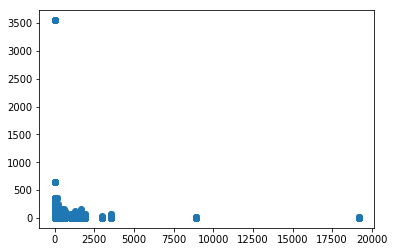

In [47]:
zerosim_lengths_1 = [lengths[0] for lengths in cc_similarity_zero_clean.values()]
zerosim_lengths_2 = [lengths[1] for lengths in cc_similarity_zero_clean.values()]

plt.scatter(zerosim_lengths_1, zerosim_lengths_2)
plt.show()

A way to find the most central entry is to simply multiply log of the two stargazer counts of the currencies. By doing this we (hopefully) eliminate pairs that have zero similarity just because one currency has next to no stargazers:

In [49]:
for key, value in cc_similarity_zero_clean.items():
    cc_similarity_zero_clean[key]=(value[0], value[1], (value[0])*(value[1]))
    

    
print(dict(sorted(cc_similarity_zero_clean.items(), key=lambda x: x[1][2], reverse=True)[:20]))

{('lbry-credits', 'virtacoinplus'): (3549, 73, 259077), ('lbry-credits', 'virtacoin'): (3549, 73, 259077), ('ripple', 'okcash'): (1663, 154, 256102), ('bitcoin', 'signatum'): (19193, 13, 249509), ('bitcoin', 'trustplus'): (19193, 12, 230316), ('ethereum', 'synergy'): (8883, 21, 186543), ('bitcoin', 'earthcoin'): (19193, 9, 172737), ('lisk', 'gambit'): (1276, 134, 170984), ('bitcoin', 'heat'): (19193, 8, 153544), ('litecoin', 'virtacoinplus'): (1932, 73, 141036), ('litecoin', 'virtacoin'): (1932, 73, 141036), ('achain', 'lbry-credits'): (39, 3549, 138411), ('bitcoin', 'pandacoin'): (19193, 7, 134351), ('siacoin', 'virtacoinplus'): (1755, 73, 128115), ('siacoin', 'virtacoin'): (1755, 73, 128115), ('zcash', 'paycoin'): (2980, 41, 122180), ('ripple', 'virtacoinplus'): (1663, 73, 121399), ('ripple', 'virtacoin'): (1663, 73, 121399), ('ethereum', 'signatum'): (8883, 13, 115479), ('bitcoin', 'evergreencoin'): (19193, 6, 115158)}


There are not many insights that can be gained from this. The only interesting thing to note is the frequency of virtacoin/virtacoinplus (which share the same repository). This indicates that the virtacoin community might be a very isolated group, doing things on their own. We will analyze this further when we get to user communities.

### Step 5: Analysis of other similarity entries

Now we get to the core. Let's analyze the currencies that have not entirely similar or dissimilar communities. First, we need to gain this data:

In [23]:
cc_similarity_nozeroone = dict((k, v) for k, v in cc_similarity.items() if v != 0 and v!=1)
print(np.mean(list(cc_similarity_nozeroone.values())))
print(len(cc_similarity_nozeroone))

0.0155639742961
6848


Maximal and minimal values:

In [59]:
print("Maximal similarities:")
print(dict(sorted(cc_similarity_nozeroone.items(), key=lambda x: x[1], reverse=True)[:10]))
print("")
print("Minimal similarities:")
print(dict(sorted(cc_similarity_nozeroone.items(), key=lambda x: x[1])[:10]))


Maximal similarities:
{('masternodecoin', 'innova'): 0.5, ('audiocoin', 'dfscoin'): 0.5, ('ultracoin', 'steps'): 0.5, ('triangles', 'britcoin'): 0.5, ('triangles', 'ratecoin'): 0.5, ('incakoin', 'steps'): 0.5, ('innova', 'desire'): 0.4, ('dynamic', 'sequence'): 0.375, ('masternodecoin', 'force'): 0.3333333333333333, ('machinecoin', 'fujicoin'): 0.3333333333333333}

Minimal similarities:
{('bitcoin', 'blitzcash'): 5.205351100931758e-05, ('bitcoin', 'magi'): 5.2058930709563226e-05, ('bitcoin', 'dynamic'): 5.207248489897938e-05, ('bitcoin', 'memetic'): 5.207248489897938e-05, ('bitcoin', 'arcticcoin'): 5.20751965838671e-05, ('bitcoin', 'ethereum-dark'): 5.20751965838671e-05, ('bitcoin', 'eternity'): 5.208062080099995e-05, ('bitcoin', 'cloakcoin'): 5.208333333333334e-05, ('bitcoin', 'fantomcoin'): 5.208333333333334e-05, ('bitcoin', 'ion'): 5.2086046148236886e-05}


For maximal values, we only get very small currencies, whose share maybe one of two or three users. For minimal values, bitcoin with its huge userbase has a spot in in all top entries (what was to be expected).

Let's explore this further with some plots. First, we want a distribution of the similarities:

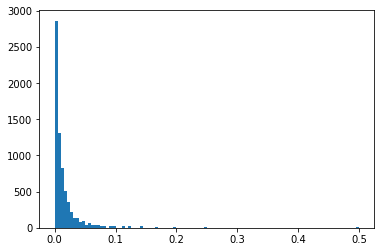

In [62]:
plt.hist(cc_similarity_nozeroone.values(), bins=100)
plt.show()

The values are exponentially distributed, which is no surprise. Also, the overall values are very low. We now want to see if there is a dependency between follower community size and community similarity. Therefore, we plot the union community size against the similarity:

In [64]:
sim_comm_sizes=[]
for pair in cc_similarity_nozeroone.keys():
    n1=len(set([x.login for x in crypto_stargazers_dict[pair[0]]]))
    n2=len(set([x.login for x in crypto_stargazers_dict[pair[1]]]))
    n12=len(common_user_dict[pair])
    
    sim_comm_sizes.append(n1+n2-n12)
    


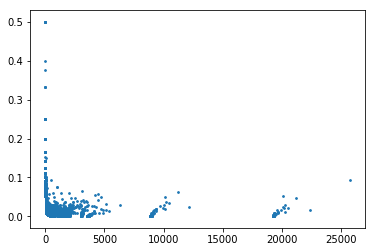

In [65]:
plt.scatter(sim_comm_sizes, cc_similarity_nozeroone.values(), s=3)
plt.show()

Most values bunch up in the bottom, the small currencies' outliers in similarity is clearly visible. Also, the points generated by the two biggest currencies bitcoin and ethereum are clearly visible as bunches towards the right. Astonishingly, there seems to be a positive correlation between the second currency's follower base and the similarity.

we now want to investigate the currencies with big following bases nearer:

### Step 6: The big fishes

To analyze the big currencies, we need to first get the cc's with the largest following bases:

In [83]:
cc_follower_count={}
for key, value in crypto_stargazers_dict.items():
    cc_follower_count[key]=len(value)

big_currencies=sorted(cc_follower_count, key=cc_follower_count.get, reverse=True)[:20]

print(big_currencies)

['bitcoin', 'ethereum', 'lbry-credits', 'zcash', 'litecoin', 'siacoin', 'ripple', 'monero', 'dogecoin', 'lisk', 'neo', 'dash', 'steem', 'steem-dollars', 'iota', 'bitshares', 'cardano', 'qtum', 'bitcoin-gold', 'peercoin']


Now we can find the similarity measures for each of these with the other 19 currencies:

In [84]:
big_cc_similarity={}
for curr in big_currencies:
    sims=[]
    other=[x for x in big_currencies if not x==curr]
    for c in other:
        f=cc_follower_count[c]
        try:
            s=cc_similarity[(curr, c)]
        except:
            s=cc_similarity[(c, curr)]
        sims.append((c, f, s))
    big_cc_similarity[curr]=sims
    
print(big_cc_similarity)

{'bitcoin': [('ethereum', 8883, 0.09223886403423459), ('lbry-credits', 3549, 0.016765771001922475), ('zcash', 2980, 0.046340427539993394), ('litecoin', 1932, 0.05141349790961577), ('siacoin', 1755, 0.022502074486259578), ('ripple', 1663, 0.02865598027127004), ('monero', 1417, 0.024608501118568233), ('dogecoin', 1398, 0.02234248547738444), ('lisk', 1276, 0.012214419938680644), ('neo', 1059, 0.016615631745394308), ('dash', 665, 0.016066311911584117), ('steem', 648, 0.011367111836068916), ('steem-dollars', 648, 0.011367111836068916), ('iota', 578, 0.00774759162036801), ('bitshares', 422, 0.009781209781209782), ('cardano', 406, 0.00538627269929209), ('qtum', 369, 0.0069490914706336546), ('bitcoin-gold', 367, 0.006742498327242781), ('peercoin', 314, 0.009313395767579034)], 'ethereum': [('bitcoin', 19193, 0.09223886403423459), ('lbry-credits', 3549, 0.022873128188250783), ('zcash', 2980, 0.06156599552572707), ('litecoin', 1932, 0.03502727533735286), ('siacoin', 1755, 0.04952644041041831), ('

Correlation between 2nd currency follower counts and similarity for each currency:

In [85]:
big_cc_corr={}
for key, value in big_cc_similarity.items():
    f=[x[1] for x in value]
    s=[x[2] for x in value]
    big_cc_corr[key]=np.corrcoef(f,s)[0,1]
    
print(big_cc_corr)

{'bitcoin': 0.89767742300277242, 'ethereum': 0.83220629141010927, 'lbry-credits': 0.31652458122177307, 'zcash': 0.46305598182874552, 'litecoin': 0.34680765299101107, 'siacoin': 0.11625349424205783, 'ripple': 0.25428079651226776, 'monero': 0.032817057939772264, 'dogecoin': 0.10012246810957526, 'lisk': -0.12295813567067974, 'neo': -0.20853378409052123, 'dash': -0.32437560673481108, 'steem': -0.12365340975863356, 'steem-dollars': -0.12365340975863356, 'iota': -0.4051362610788527, 'bitshares': -0.34144710228970293, 'cardano': -0.43237566035908009, 'qtum': -0.38220089720814931, 'bitcoin-gold': -0.35769560134738554, 'peercoin': -0.2030773001336329}


The observation mentioned before of positive correlation between followers and similarity only holds for the big currencies. It even completely flips for currencies outside of the top 10. We can visualize that:

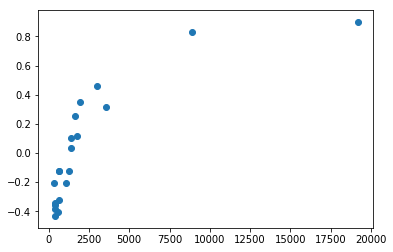

In [86]:
big_followers=[cc_follower_count[curr] for curr in big_cc_corr.keys()]

plt.scatter(big_followers, big_cc_corr.values())
plt.show()

So for the biggest currencies we can say that follower similarity increases with the size of the second currency, for the less big currencies it is the other way around.

# Analyzing followers vs. marketcap

## Goal: Discover relationships between follower count and marketcap

### Step 1: Get the data and add to the network

In [3]:
# Load data
with open('./name_marketcap_dict.pickle', 'rb') as handle:
    name_marketcap_dict = pickle.load(handle)

In [4]:
print(name_marketcap_dict['bitcoin'])

179941892291


In [5]:
# Add marketcap as node attribute
for name, value in name_marketcap_dict.items():
    try:
        Stargaze_Network.node[name]['marketcap'] = value
    except:
        True


In [6]:
print(Stargaze_Network.node['bitcoin']['marketcap'])

179941892291


### Step 2: Get an overview over the relationship between marketcap and followers

First, we simply calculate the correlation between the two values:

In [7]:
star_nos = []
marketcaps = []
for key, value in crypto_stargazers_dict.items():
    star_nos.append(len(value))
    marketcaps.append(name_marketcap_dict[key])
    
print("Correlation between follower count and marcetcap:", np.corrcoef(star_nos, marketcaps)[0,1])
    

Correlation between follower count and marcetcap: 0.942808533959


This looks very good at first glance but plotting the dots reveals that bitcoin and ethereum have such a big marketcap and follower basis that it renders the other currencies irrelevant:

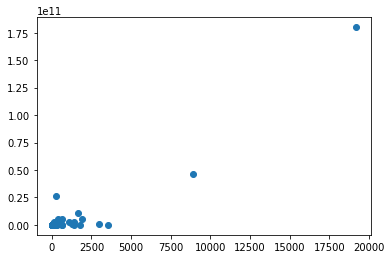

In [8]:
plt.scatter(x=star_nos, y=marketcaps)
plt.show()

When looking at the same plot without the two currencies, we get a totally different picture and a much worse correlation:

Correlation between follower count and marcetcap without bitcoin, ethereum: 0.27329010851


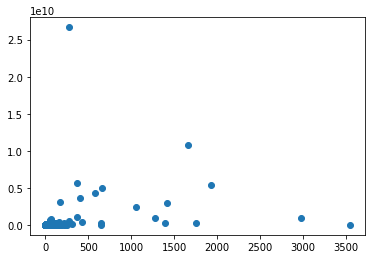

In [9]:
print("Correlation between follower count and marcetcap without bitcoin, ethereum:", np.corrcoef(star_nos[2:], marketcaps[2:])[0,1])

plt.scatter(x=star_nos[2:], y=marketcaps[2:])
plt.show()

We can clearly see that there is no strong dependency between the two variables. Thus, we will try to find other variables that influence the marketcap.

In [10]:
with open('./crypto_repo_dict.pickle', 'rb') as handle:
    crypto_repo_dict = pickle.load(handle)

In [11]:
print(crypto_repo_dict["nem"])
print(crypto_repo_dict["ethereum"].created_at)
print(crypto_repo_dict["dogecoin"].created_at)
print(crypto_repo_dict["nolimitcoin"].created_at)

None
2013-12-26 13:05:46
2013-12-06 11:38:05
2016-08-10 17:31:48


### Step 3: New variables

We now want to find other variables that could have an impact on marketcap. First, we look at the time a currency's repository was created. We then calculate its age in days (until 2nd December 2017) and compare it to the monetary value. Because bitcoin and ethereum were some of the first currencies and are the biggest, we suspect a correlation.

In [12]:
# All repository data
with open('./crypto_repo_dict.pickle', 'rb') as handle:
    crypto_repo_dict = pickle.load(handle)

today = datetime.date.today()
crypto_age_dict = {}

# Get age of currencies
for curr in crypto_repo_dict.keys():
    # Get creation time and Calculate days
    try:
        created = crypto_repo_dict[curr].created_at.date()
        days = (today-created).days
        crypto_age_dict[curr]=days
    except:
        days = None


Correlation between age and marketcap: 0.17400441758


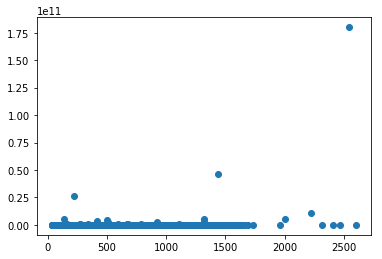

In [13]:
ages=[]
for key, value in crypto_stargazers_dict.items():
    ages.append(crypto_age_dict[key])

# Correlation    
print("Correlation between age and marketcap:", np.corrcoef(ages, marketcaps)[0,1])

# Plot
plt.scatter(x=ages, y=marketcaps)
plt.show()

There is no good correlation, because many of the old currencies never made it big despite their age. We will therefore put this on ice.

Another idea would be the number of forks. If you want to experiment with code and maybe use it for your purposes, you need to create a fork. The idea is that cryptocurrencies with a high marketcap will have a high number of forks.

In [14]:
crypto_forks_dict = {}

# Get age of currencies
for curr in crypto_repo_dict.keys():
    # Get creation time and Calculate days
    try:
        forks = crypto_repo_dict[curr].forks_count
        crypto_forks_dict[curr]=forks
    except:
        forks = None

Correlation between age and marketcap: 0.963190938991


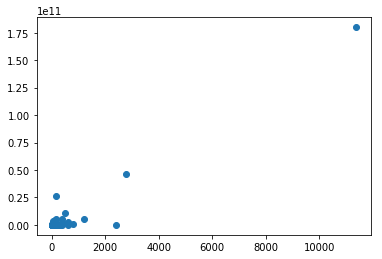

In [15]:
forks=[]
for key, value in crypto_stargazers_dict.items():
    forks.append(crypto_forks_dict[key])

# Correlation    
print("Correlation between age and marketcap:", np.corrcoef(forks, marketcaps)[0,1])

# Plot
plt.scatter(x=forks, y=marketcaps)
plt.show()

Again, bitcoin and ethereum falsify the result, so we take a closer look at the others:

Correlation between age and marketcap: 0.226278710936


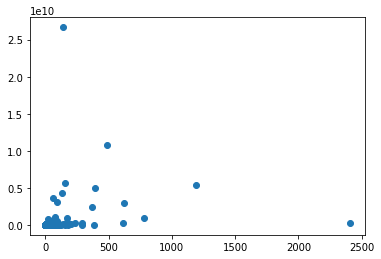

In [16]:
# Correlation    
print("Correlation between age and marketcap:", np.corrcoef(forks[2:], marketcaps[2:])[0,1])

# Plot
plt.scatter(x=forks[2:], y=marketcaps[2:])
plt.show()

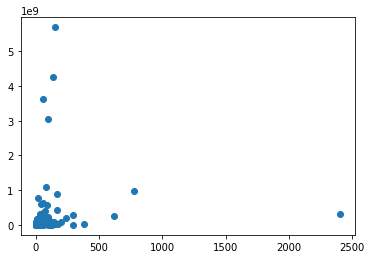

In [46]:
plt.scatter(x=forks[8:], y=marketcaps[8:])
plt.show()

This metric is very similar to the follower count. When setting up a regression model to predict the marketcap we thus have to account for multicollinearity.

Now we try our luck at putting all three of these variables into one model to predict the marketcap. We will therefore leave out bitcoin and ethereum, as they are clear outliers. The other datapoints will be used to create a linear regression model with the three covariates followers, age and forks.

In [51]:
# split dataset into training and test data
X = np.column_stack((star_nos, ages, forks))
y = np.array(marketcaps).reshape(-1,1)
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.4, random_state=0)


model=lm.LinearRegression(fit_intercept=True)
model.fit(X_train, y_train)
y_pred=model.predict(X_test)

# The coefficients
print('Coefficients: \n', model.intercept_, model.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % met.mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % met.r2_score(y_test, y_pred))

Coefficients: 
 [ -1.67991857e+08] [[  2137705.93287094  12061439.86071988]]
Mean squared error: 8780730323030544384.00
Variance score: 0.37


Coefficients: 
 -40677168.6825 [ 3975598.31351594]
Mean squared error: 68166297210300276736.00
Variance score: 0.67


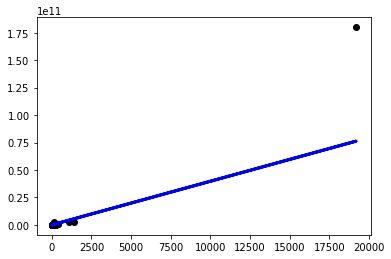

In [57]:
# split dataset into training and test data
X2 = np.array(star_nos).reshape(-1,1)
y2 = np.array(marketcaps)
X2_train, X2_test, y2_train, y2_test = ms.train_test_split(X2, y2, test_size=0.4, random_state=1234)


model2=lm.LinearRegression(fit_intercept=True)
model2.fit(X2_train, y2_train)
y2_pred=model2.predict(X2_test)

# The coefficients
print('Coefficients: \n', model2.intercept_, model2.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % met.mean_squared_error(y2_test, y2_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % met.r2_score(y2_test, y2_pred))

plt.scatter(X2_test, y2_test,  color='black')
plt.plot(X2_test, y2_pred, color='blue', linewidth=3)
plt.show()

# Wikipedia analysis
## Goal: Insights about the texts of Wikipedia articles of the different currencies

### Step 1: Summary statistics

In [4]:
# Get data
with open('./currency_pages_dict.pickle', 'rb') as handle:
    currency_pages_dict = pickle.load(handle)

We first need to remove all references from the articles. This can be done by finding them with a regular expression and then replacing them with an empty string. To ease the process, we will also delete all linebreaks. We don't need them anyways:

In [5]:
# remove references
for key, value in currency_pages_dict.items():
    # remove linebreaks
    value=re.sub(r"\n",r" ", value)
    
    # remove two different types of references
    val=re.sub(r"<ref.+?(?=/ref|/>)",r"", value)
    currency_pages_dict[key]=re.sub(r"ref", r"", val)
    


Next, we need to tokenize the data and remove things such as numbers, punctuation and stopwords that carry no information about the text:

In [6]:
# clean data, tokenize
def clean_page(text):
    
    # tokenize
    tokens=nltk.word_tokenize(text)
    
    # Exclude punctuation, numbers, set to lowercase
    tokens_p=[t for t in tokens if re.search(r"\w+", t)]
    tokens_n=[t.lower() for t in tokens_p if re.search(r"\d+", t)==None]
    
    # get stopwords, remove them
    stopwords = nltk.corpus.stopwords.words('english')
    tokens_s = [t for t in tokens_n if t not in stopwords]
    return tokens_s

In [7]:
# clean pages
currency_pages_clean = {}
for key, value in currency_pages_dict.items():
    words=clean_page(value)
    currency_pages_clean[key.lower()]=words

# Example
print(currency_pages_clean["bitcoin"])

['pp-protect|small=yes', 'use', 'dmy', 'dates|date=october', 'infobox', 'currency', 'bitcoin', 'logo.svg', 'iso_code', 'xbt', 'efn|unofficial.|group=infobox', 'prevailing', 'bitcoin', 'logo', 'issuing_authority', 'decentralised', 'system|decentralized', 'issuing_authority_title', 'administration', 'date_of_introduction', 'start', 'date', 'using_countries', 'worldwide', 'inflation_title', 'monetary', 'inflation|supply', 'growth', 'inflation_rate', 'bitcoins', 'per', 'block', 'approximately', 'every', 'ten', 'minutes', 'mid', 'afterwards', 'bitcoins', 'per', 'block', 'years', 'next', 'halving', 'halving', 'continues', 'million', 'bitcoins', 'issued', 'inflation_source_date', 'millibitcoin/', 'satoshi/', 'sat', 'symbol', 'efn|the', 'symbol', 'encoded', 'unicode', 'version', 'position', 'sign', 'currency', 'symbols', 'unicode', 'block', '|currency', 'symbols', 'block', 'june', '|group=infobox', 'used_coins', 'unspent', 'outputs', 'transactions/', 'rp|ch', 'footnotes', 'notelist|group=infob

In [8]:
# page lengths:
for key, value in dict(sorted(currency_pages_clean.items(), key=lambda x: len(x[1]), reverse=True)).items():
    print(key+": "+str(len(value))+" words")

ripple (payment protocol): 3437 words
bitcoin: 3201 words
ethereum: 1716 words
cryptonote#digitalnote (xdn): 1697 words
nem (cryptocurrency): 1419 words
dogecoin: 1309 words
burstcoin: 938 words
nxt: 916 words
potcoin: 903 words
monero (cryptocurrency): 857 words
peercoin: 840 words
ark ecosystem: 690 words
ethereum classic: 672 words
namecoin: 664 words
dash (cryptocurrency): 635 words
ubiq: 631 words
titcoin: 566 words
emercoin: 545 words
gridcoin: 510 words
bitcoin cash: 485 words
auroracoin: 450 words
primecoin: 434 words
vertcoin: 419 words
swiftcoin: 387 words
coinye: 350 words
mazacoin: 315 words
litecoin: 260 words
sixeleven: 252 words
decred: 236 words
zcash: 189 words
synereo: 188 words
blackcoin: 148 words
mastercoin: 5 words
iota (cryptocurrency): 3 words
waves platform: 3 words


Again, the bigger currencies have the longer Wikipedia articles. Interestingly, bitcoin does not have the longest article. This achievement goes to the currency [Ripple](https://en.wikipedia.org/wiki/Ripple_%28payment_protocol%29). This is due to the fact that Ripple is not only a currency, but also a payment protocol that is used by some of the largest banks and other powerful institutions in the world. Therefore, the Wikipedia article does not only cover the currency and is susequently longer.

### Step 2: A wordcloud for all articles

Now, we want to go from looking at articles to looking at specific words. We therefore compute a statistic of how often each word occurs in the union of all articles. 
To get this information, we first need to get a list of all the unique words that are used in the at least one of the articles:

In [9]:
# Get all vocabulary 
vocab = []
for text in currency_pages_clean.values():
    vocab=vocab+text
    
vocab=set(vocab)

print("Total unique words:", len(vocab))

Total unique words: 6729


Now we can count how often the words are used:

In [10]:
# All texts into one list of tokens:
all_texts=sum(list(currency_pages_clean.values()), [])

# Build frequency distribution
all_curr_freqdist=nltk.FreqDist(all_texts)

for key, value in dict(sorted(all_curr_freqdist.items(), key=lambda x: x[1], reverse=True)).items():
    print(key+": "+str(value)+" occurences")

bitcoin: 380 occurences
network: 187 occurences
's: 176 occurences
currency: 166 occurences
ripple: 161 occurences
blockchain: 158 occurences
block: 150 occurences
ethereum: 129 occurences
transaction: 124 occurences
cryptocurrency: 121 occurences
system: 120 occurences
transactions: 120 occurences
category: 120 occurences
cryptocurrencies: 97 occurences
one: 94 occurences
software: 88 occurences
wallet: 88 occurences
also: 87 occurences
used: 85 occurences
use: 82 occurences
new: 81 occurences
first: 80 occurences
coins: 78 occurences
users: 77 occurences
mining: 77 occurences
number: 70 occurences
protocol: 68 occurences
bank: 67 occurences
currencies: 66 occurences
public: 65 occurences
code: 64 occurences
based: 63 occurences
using: 62 occurences
language: 62 occurences
development: 62 occurences
key: 61 occurences
nem: 61 occurences
name: 60 occurences
user: 60 occurences
community: 59 occurences
proof-of-work: 58 occurences
per: 57 occurences
exchange: 57 occurences
digital: 56 o

partnership: 4 occurences
id: 4 occurences
benefit: 4 occurences
measure: 4 occurences
longer: 4 occurences
cryptocurrencies./: 4 occurences
primecoins: 4 occurences
implements: 4 occurences
==features==: 4 occurences
relationship: 4 occurences
attempts: 4 occurences
adjustment: 4 occurences
efficiently: 4 occurences
alt: 4 occurences
ryan: 4 occurences
preview: 4 occurences
banco: 4 occurences
manner: 4 occurences
threat: 4 occurences
float: 4 occurences
background: 4 occurences
customers: 4 occurences
fidor: 4 occurences
holds: 4 occurences
government: 4 occurences
royal: 4 occurences
canada: 4 occurences
star: 4 occurences
net: 4 occurences
offers: 4 occurences
identification: 4 occurences
counterparty: 4 occurences
specified: 4 occurences
failed: 4 occurences
great: 4 occurences
review: 4 occurences
difficult: 4 occurences
exists: 4 occurences
third-party: 4 occurences
read: 4 occurences
good: 4 occurences
escrow: 4 occurences
period: 4 occurences
press: 4 occurences
realize: 4 occ

communicating: 1 occurences
r|: 1 occurences
primer: 1 occurences
''payer: 1 occurences
z: 1 occurences
broadcasting: 1 occurences
|broadcast: 1 occurences
readily: 1 occurences
validate: 1 occurences
six: 1 occurences
hour: 1 occurences
oversight: 1 occurences
conventional: 1 occurences
banknote|bills: 1 occurences
promissory: 1 occurences
month.png|thumb|number: 1 occurences
forth: 1 occurences
|forth: 1 occurences
language.: 1 occurences
''inputs: 1 occurences
''outputs: 1 occurences
designates: 1 occurences
recipients: 1 occurences
payer./: 1 occurences
satoshis: 1 occurences
fee./: 1 occurences
ledgerwallet.jpg|thumb|an: 1 occurences
webbased: 1 occurences
paying: 1 occurences
optional./: 1 occurences
process/: 1 occurences
prioritize: 1 occurences
priority: 1 occurences
older: 1 occurences
inputs./: 1 occurences
visual.svg|thumb|simplified: 1 occurences
reality: 1 occurences
picking: 1 occurences
reverse: 1 occurences
mathematically: 1 occurences
compromising: 1 occurences
key-pa

roadmap: 1 occurences
releases./: 1 occurences
layers: 1 occurences
integration: 1 occurences
turing-complete: 1 occurences
main|monero: 1 occurences
monero/: 1 occurences
cryptonotes: 1 occurences
slower: 1 occurences
praised: 1 occurences
todd: 1 occurences
laan./: 1 occurences
crytonote: 1 occurences
mymonero: 1 occurences
teamed: 1 occurences
cryptographers: 1 occurences
aliasing: 1 occurences
openalias: 1 occurences
urs: 1 occurences
mnemonic: 1 occurences
seeds: 1 occurences
vanets: 1 occurences
ukrainian: 1 occurences
premine: 1 occurences
instamine: 1 occurences
hardforked: 1 occurences
cryptonite: 1 occurences
carried: 1 occurences
bring: 1 occurences
bbr: 1 occurences
boolberry/: 1 occurences
improves: 1 occurences
unlinkable: 1 occurences
ring-signatures: 1 occurences
===daemon-wallet: 1 occurences
architecture===: 1 occurences
executables: 1 occurences
laan: 1 occurences
writes: 1 occurences
imo: 1 occurences
'simplewallet: 1 occurences
command-line: 1 occurences
remembers:

We can see that the most used words are mostly currency names (e.g. bitcoin, ethereum), financial terms (e.g. transaction, wallet) or technical terms (e.g. wallet, blockchain). We get a nicer vizualisation of this statiatic by using a wordcloud:

In [22]:
# orange colors
def orange_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(%d, 100%%, %d%%)" % (random.randint(21, 30), random.randint(40,80))


Wordcloud for all articles:


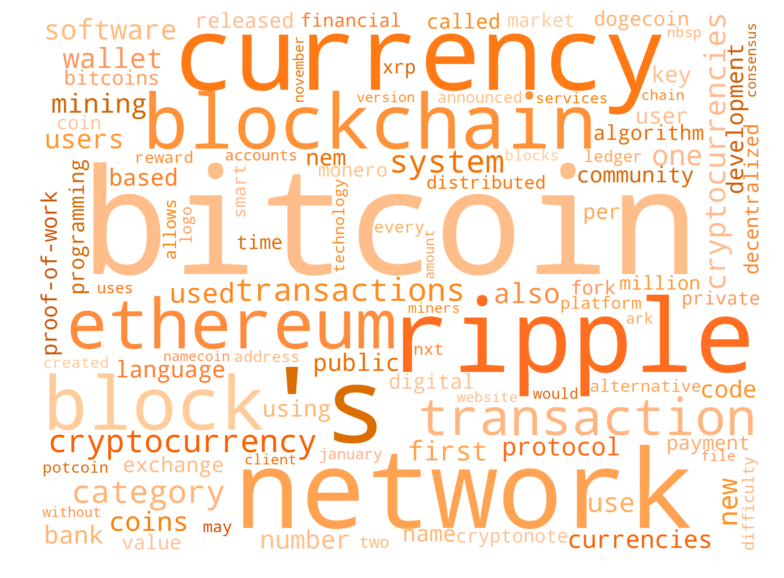

In [28]:
import wordcloud

print("Wordcloud for all articles:")
wor = wordcloud.WordCloud(width=2000, height=1500, max_words=100, background_color="white").generate_from_frequencies(all_curr_freqdist)
wor.recolor(color_func=orange_color_func, random_state=3)
plt.figure(figsize=(20,10))
plt.imshow(wor, interpolation="bilinear", cmap=plt.cm.gray)
plt.axis("off")
plt.show()

### Step 3: Setting up tf-idf

We do not only want to see which currencies are the ones with the longest articles and which words are used the most, but also want to discover potential trends and unique words that might be used in specific articles more often than in others. In ordes to do this, we calculate the tf-idf scores of each Wikipedia page. tf-idf is short for **term frequency - inverse document frequency** and provides a way to measure how characteristic a word is for a text compared to other texts. It consists of two parts:
* **tf(term frequency)** of word $w$ in text $t$ is simply the word count $f(w, t)$ in a text divided by the total number of words: $$tf(w, t)=\frac{f(w, t)}{\sum_{w_i} f(w_i, t)}$$.
* **idf (inverse document frequency)** of a word $w$ in a corpus of texts $C$ is the logarithm of the document count divided by the number of documents the word is found in: $$idf(w, C)=\frac{|C|} {|\{c \in C: w \in c\}|}$$

* The **tf-idf** score of a word in a document in a corpus is then: $$tfidf(w, t, C)=tf(w,t)\cdot idf(w, C)$$

It takes the term frequency of the word in the text and then penalizes this score if the word can be found in too many texts. Therefore, the words with the highest tf-idf will be the ones that are found in the text unusually often.


We can use the *sklearn* library to calculate the actual tf-idf scores:

In [259]:
# Calculate tfidf

from sklearn.feature_extraction.text import TfidfVectorizer
import math
 
curr_tfidf = TfidfVectorizer(vocabulary=vocab)
 
# Fit the TfIdf model
curr_tfidf_fit = curr_tfidf.fit_transform(currency_pages_dict.values())

tfidf_matrix=curr_tfidf_fit.todense()

In [260]:
# Example: word 'bitcoin' in aricle for bitcoin
print("Aritcle:", list(currency_pages_dict.keys())[0])
print('tfidf("bitcoin") = '+str(tfidf_matrix[0, curr_tfidf.vocabulary_['bitcoin']]))

Aritcle: Bitcoin
tfidf("bitcoin") = 0.582246364541


After we calculated the scores, we can go into the analysis.

### Step 4: Getting the highest entries

As a first step, we will look at the 10 highest tf-idf values for each article and see what trends or characteristics can be spotted:

In [254]:
# Get highest 10 entries for each article
top_tfidf_dict={}
for i in range(len(currency_pages_dict)):
    # currency name
    curr=list(currency_pages_dict.keys())[i]
    
    # tfidf-scores
    scores=tfidf_matrix[i].tolist()[0]
    
    # top 10 entries indices
    ind=sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:10]
    # scores
    val=[scores[j]for j in ind]

    # words
    voc_switched = {y:x for x,y in curr_tfidf.vocabulary_.items()}
    words=[voc_switched[j]for j in ind]
    
    # create dict entry
    items=[(words[k], val[k]) for k in range(10)]
    top_tfidf_dict[curr]=items

In [255]:
# Print
for key, value in top_tfidf_dict.items():
    print(key+":")
    for t in value:
        print(t[0]+": tfidf="+str(t[1]))
    print("\n")

Bitcoin:
bitcoin: tfidf=0.5822463645407631
bitcoins: tfidf=0.3064110619380094
transaction: tfidf=0.14800171151626879
nakamoto: tfidf=0.12271477315498218
transactions: tfidf=0.11865913159225239
blockchain: tfidf=0.11174130438671416
network: tfidf=0.10669864386731547
block: tfidf=0.09924569008969537
satoshi: tfidf=0.09784298929762883
wallets: tfidf=0.09400466457342838


Litecoin:
litecoin: tfidf=0.6694823016098361
ltc: tfidf=0.2053951939271206
memory: tfidf=0.16560440595213693
bitcoin: tfidf=0.1350930614850476
minutes: tfidf=0.11814393557820638
scrypt: tfidf=0.11320722083518482
algorithm: tfidf=0.10628576758850247
market: tfidf=0.09714234287228668
client: tfidf=0.09065935507001295
november: tfidf=0.08769876067316346


Namecoin:
namecoin: tfidf=0.6776050529428588
code: tfidf=0.1927355565775024
bit: tfidf=0.1397143423620621
nmc: tfidf=0.1364262990002076
bitdns: tfidf=0.12183948070964663
dns: tfidf=0.11642861863505173
bitcoin: tfidf=0.11377263344705237
example: tfidf=0.10715214864752755
add

The most apparent observation we can get from this, is the fact that all currencies have their name as the top tf-idf score. This was expected. Other interesting observations may be:
* For **[bitcoin](https://en.wikipedia.org/wiki/Bitcoin)**, the name "Nakamoto" has a very high score. [Satoshi Nakamoto](https://en.wikipedia.org/wiki/Satoshi_Nakamoto) was the head of the research group that founded bitcoin in 2009. Also, the technology behind all cryptocurrencies, blockchain, has a high score.
* For **[litecoin](https://en.wikipedia.org/wiki/Litecoin)**, the words "memory" and "scrypt" have high scores. The technology of litecoin uses the [scrypt](https://en.wikipedia.org/wiki/Scrypt) technique to make mining more and more expensive.
* The currency **[dogecoin](https://en.wikipedia.org/wiki/Dogecoin)** has a strong association with the forum reddit, hence the high tf-idf score.
* As already mentioned, **[Ripple](https://en.wikipedia.org/wiki/Ripple_%28payment_protocol%29)** has high use in the financial sector, which can also be seen by the words "bank" and "financial" having high scores.
* **[Coinye](https://en.wikipedia.org/wiki/Coinye)** is a pun on US star Kanye West. The currency made news in 2014, when the rapper filed a lawsuit against the creators, which resulted in the discontinuation of the currency. The tf-idf scores are therefore highly influenced by this.
* **[monero](https://en.wikipedia.org/wiki/Monero_%28cryptocurrency%29)** is all sbout privacy, decentralization and confidentialness, what is heavily discussed reflected in its Wikipedia article.

There are many more characteristics and stories that can be found within the tf-idf scores, but this shall be enough for now.